 # Visualizing the William's Flats Fire and fire-weather 
 

# Load up environment

In [1]:
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from geocube.api.core import make_geocube
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

## Read in weather station data

_Setup and helper functions_

In [2]:
files = s3.ls("s3://veda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/")
len(files)

295

In [3]:
# Function organizes weather station records into lat and lon
st_id_map = pd.read_csv("/projects/my-public-bucket/fire_weather_vis/ref_data/isd-history.csv") ## For mappting ID's to lat lon

def st_avail(files, inter_type = "spline.HourlyFWIFromHourlyInterpContinuous", st_id_map = st_id_map):
    file_inter = []
    for path in files:
        if inter_type in path:
            file_inter.append(path)

    df = []
    for i in file_inter:
        pt_1 = re.sub("veda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/", "", i)
        #pt_2 = re.sub(".spline.DailyFWIfromHourlyInterp.csv","",  pt_1)
        pt_2 = re.sub(("." + inter_type + ".csv"),"",  pt_1)
        pt_3 = pt_2.split("-")
        usaf = re.sub(r'[^0-9]', '',pt_3[0]) ## Sometimes ID had extra characters? 
        #print(usaf)
        wban = re.sub(r'[^0-9]', '',pt_3[1]) 
        #print(wban)
        
        st = st_id_map.loc[(st_id_map.USAF == usaf) | (st_id_map.WBAN == wban)]
        #print(st)
        if(st.empty):
            print("Empty Dataframe")
            break
        
        lat = st.LAT.iloc[0]
        lon = st.LON.iloc[0]

        df.append({
            "File_path": i,
            "Lat": lat,  
            "Lon": lon,
            "USAF": usaf,
            "WBAN": wban
        })
   

   
    return(pd.DataFrame(df))

# Helper Variable
stations = st_avail(files)

In [4]:
# Test code 
#dat_time = dat
#
#dat_time.HH = dat_time.HH.astype('int')
#dat_time.HH = dat_time.HH.astype('str')
#
#
#def hour_fix (hr):
#    small_hr = ["0","1","2","3","4","5","6","7","8","9"]
#    append = ""
#    
#    if (hr in small_hr):
#        append = "0"
#    hr = append + hr
#    
#    return(hr)
#    
#dat_time['HH_format'] = dat_time.HH.apply(hour_fix)   
#dat_time['time'] = pd.to_datetime(dat_time['YYYY'].astype(str) +"-"+  dat_time['MM'].astype("str") +"-"+  dat_time['DD'].astype("str") + " " + dat_time['HH_format'].astype('str'), format='%Y-%m-%d %H')
#
#dat_time

# Function to fix single-digit hour, because the strtime format is not supported here >:|
def hour_fix (hr):
    small_hr = ["0","1","2","3","4","5","6","7","8","9"]
    append = ""
    
    if (hr in small_hr):
        append = "0"
    hr = append + hr
    
    return(hr)

## Function for parsing into datetime objects
# Takes a pandas dataframe of the same format as found: 
#'s3://veda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/727850-24157.spline.HourlyFWIFromHourlyInterpContinuous.csv'

def date_convert(dat_time):
    dat_time.HH = dat_time.HH.astype('int') # Drop #.0
    dat_time.HH = dat_time.HH.astype('str')
    dat_time['HH_format'] = dat_time.HH.apply(hour_fix)
    dat_time['time'] = pd.to_datetime(dat_time['YYYY'].astype(str) +"-"+  dat_time['MM'].astype("str") +"-"+  dat_time['DD'].astype("str") + " " + dat_time['HH_format'].astype('str'), format='%Y-%m-%d %H')

    return(dat_time)

In [14]:
## Function that for given lat lon, makes organized dat object of station timeseries

def get_st(lat, lon, stations = stations, flag_bad = True):
        
    st = stations.loc[(stations.Lat == lat) & (stations.Lon == lon)]
    #dat = pd.read_csv("s3://veda-data-store-staging/EIS/other/station-FWI/20000101.20220907.hrlyInterp/FWI/727970-94240.spline.DailyFWIfromHourlyInterp.csv")
    dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
    dat = date_convert(dat)
    
    if flag_bad:
        mask = dat['OBSMINUTEDIFFTEMP'].loc[dat.OBSMINUTEDIFFTEMP > 20]  ## Kluge. Basically, use this as a flag. 
        dat.iloc[mask.index, 4:-4 ] = np.nan
    
    return(dat)


In [15]:
#from datetime import datetime
#dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H')
#dat = pd.read_csv(("s3://" + st.File_path.iloc[0]),index_col = False,  parse_dates={'time': ['YYYY', 'MM', 'DD', 'HH']}, date_parser=dateparse)
#set(dat)
#test =pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
#test

In [16]:
## Function that takes in lat and lon and plots timeseries of all the variables

def plot_st(lat, lon, all_plot = True, stations = stations, times = "none_passed", flag_bad = True, time_start = "default", time_end = "default"):
    
    st = stations.loc[(stations.Lat == lat) & (stations.Lon == lon)]
    #dat = pd.read_csv("s3://veda-data-store-staging/EIS/other/station-FWI/20000101.20220907.hrlyInterp/FWI/727970-94240.spline.DailyFWIfromHourlyInterp.csv")
    dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)
    
    
    if flag_bad:
        mask = dat['OBSMINUTEDIFFTEMP'].loc[dat.OBSMINUTEDIFFTEMP > 20]  ## Kluge. Basically, use this as a flag. 
        dat.iloc[mask.index, 3:-4 ] = np.nan
        
    if (times == "none_passed"):
        times = np.arange(np.datetime64('2000-01-01 12:00:00'),
                          np.datetime64('2022-09-24 20:00:00'), np.timedelta64(60, 'm')) # Generate timesereis on fly bc parsing files headache # Time shifted????
        dat["time"] = times
        
        if ((time_start != "default") & (time_end != "default")):
            
            dat = dat[(dat['time'] > time_start) & (dat['time'] < time_end )] # For "zooming" to particular time

    for col in dat.columns[4:-6]:
        plt.figure()
        plt.plot(dat["time"], dat[col])
        plt.xlabel('Year')
        plt.ylabel('')
        plt.title(col)
        plt.xticks(rotation = 45)

In [17]:
## Functions to extract the closest station for given lat lon. 
# Note that the output has different rounding defaults than print statement

def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295
    hav = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2
    return 12742 * asin(sqrt(hav))

def closest(data, v):
    mn = min(data, key=lambda p: distance(v['Lat'],v['Lon'],p['Lat'],p['Lon']))
    dist = distance(v['Lat'],v['Lon'], mn['Lat'], mn['Lon'])
    print("The closest station is", dist, "km away." )
    return mn

def closest_srch(data, v):
    mn = min(data, key=lambda p: distance(v['Lat'],v['Lon'],p['Lat'],p['Lon']))
    dist = distance(v['Lat'],v['Lon'], mn['Lat'], mn['Lon'])
    mn = pd.DataFrame([mn])
    mn['dist_km'] = dist 
    return mn 


*Station Closest to William Flats fire*

In [18]:
# Find the closest station
foi = {'Lat':47.98, 'Lon': -118.624} ## Centriod of william flats polygon from yang's snapshot
st_dict = stations[['Lat', 'Lon']].to_dict('records')
cls_st = closest(st_dict, foi) ## Different rounding than DF value if printed!!!!


cls_st_srch = closest_srch(st_dict, foi)
cls_st_srch
#print(cls_st)
# Plot variables
#plot_st(lat = cls_st["Lat"], lon = cls_st["Lon"], 
#        stations = stations, 
#        time_start = '2019-08-01 01:00:00',  ## Aproximate duration of fire
#        time_end = '2019-08-11 23:00:00')


The closest station is 91.02544632202617 km away.


Lat      Lon    dist_km
0  47.622 -117.528  91.025446

# Read in largefire dataset

In [19]:
lf_files = glob.glob('/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2019/Largefire/*4655*') ## ID of William's Flats

# unique lf ids if more than one, but works with only one too!
lf_ids = list(set([file.split('Largefire/')[1].split('_')[0] for file in lf_files])) 
print('Number of LF ids:',len(lf_ids)) # Should be one, just william's flats


largefire_dict = dict.fromkeys(lf_ids)
for lf_id in lf_ids:
    most_recent_file = [file for file in lf_files if lf_id in file][-1]
    largefire_dict[lf_id] = most_recent_file
    
gdf = pd.concat([gpd.read_file(file,layer='perimeter') for key, file in largefire_dict.items()], 
                   ignore_index=True)

#gdf

Number of LF ids: 1


In [20]:
def load_large_fire(fireID):
    lf_files = glob.glob('/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2019/Largefire/*' + fireID + '*') ## ID of William's Flats
    lf_ids = list(set([file.split('Largefire/')[1].split('_')[0] for file in lf_files])) 
    largefire_dict = dict.fromkeys(lf_ids)
    
    for lf_id in lf_ids:
         most_recent_file = [file for file in lf_files if lf_id in file][-1]
         largefire_dict[lf_id] = most_recent_file
    
    gdf = pd.concat([gpd.read_file(file,layer='perimeter') for key, file in largefire_dict.items()], 
                   ignore_index=True)
    return gdf
gdf_func = load_large_fire('4655')

In [21]:
gdf

n_pixels  n_newpixels       farea     fperim   flinelen  duration  \
0       2032          173  183.686606  70.399024  23.719117       6.0   
1       1859          595  176.468468  67.135400  42.477243       5.5   
2        781          101   76.418223  36.902706  18.749463       3.5   
3        832           51   77.994854  38.069408  12.306560       4.0   
4        472          176   50.155944  30.207285  17.828094       1.5   
5        511           39   51.341665  30.254317   8.322687       2.0   
6        647          136   61.250741  32.708999  13.406660       2.5   
7        680           33   63.815573  33.938029   9.308030       3.0   
8         17           17    2.991894   7.507975   7.507975       0.0   
9        296           87   41.175108  27.732792  13.214767       1.0   
10       209          192   34.308269  26.794744  22.150921       0.5   
11      1058          226  105.731771  47.476268  26.003775       4.5   
12      1264          206  115.744774  49.725398  25.113222       5.0   
13      2057            0  185.537556  70.933416   0.000000       8.0   
14      2057            0  185.537556  70.933416   0.000000       8.0   
15      2057            0  185.537556  70.933416   0.000000       8.0   
16      2057            0  185.537556  70.933416   0.000000       8.0   
17      2057            0  185.537556  70.933416   0.000000       8.0   
18      2057            0  185.537556  70.933416   0.000000       8.0   
19      2057            0  185.537556  70.933416   0.000000       8.0   
20      2057            0  185.537556  70.933416   0.000000       8.0   
21      2057            0  185.537556  70.933416   0.000000       8.0   
22      2057            0  185.537556  70.933416   0.000000       8.0   
23      2057            0  185.537556  70.933416   0.000000       8.0   
24      2057            0  185.537556  70.933416   0.000000       8.0   
25      2057            0  185.537556  70.933416   0.000000       8.0   
26      2057            0  185.537556  70.933416   0.000000       8.0   
27      2057            0  185.537556  70.933416   0.000000       8.0   
28      2055            0  185.333198  70.903855   0.000000       6.5   
29      2055            0  185.333198  70.903855   0.000000       6.5   
30      2057            2  185.537556  70.933416   1.745681       8.0   
31      2057            0  185.537556  70.933416   0.000000       8.0   
32      2057            0  185.537556  70.933416   0.000000       8.0   
33      2057            0  185.537556  70.933416   0.000000       8.0   
34      2057            0  185.537556  70.933416   0.000000       8.0   
35      2057            0  185.537556  70.933416   0.000000       8.0   
36      2057            0  185.537556  70.933416   0.000000       8.0   
37      2057            0  185.537556  70.933416   0.000000       8.0   
38      2057            0  185.537556  70.933416   0.000000       8.0   
39      2057            0  185.537556  70.933416   0.000000       8.0   
40      2057            0  185.537556  70.933416   0.000000       8.0   
41      2057            0  185.537556  70.933416   0.000000       8.0   
42      2057            0  185.537556  70.933416   0.000000       8.0   
43      2057            0  185.537556  70.933416   0.000000       8.0   
44      2057            0  185.537556  70.933416   0.000000       8.0   
45      2057            0  185.537556  70.933416   0.000000       8.0   
46      2057            0  185.537556  70.933416   0.000000       8.0   
47      2057            0  185.537556  70.933416   0.000000       8.0   
48      2057            0  185.537556  70.933416   0.000000       8.0   
49      2055           23  185.333198  70.903855   7.273700       6.5   
50      2057            0  185.537556  70.933416   0.000000       8.0   
51      2057            0  185.537556  70.933416   0.000000       8.0   
52      2057            0  185.537556  70.933416   0.000000       8.0   
53      2057            0  185.537556  70.933416   0.000000   

# Plot large fire dataset

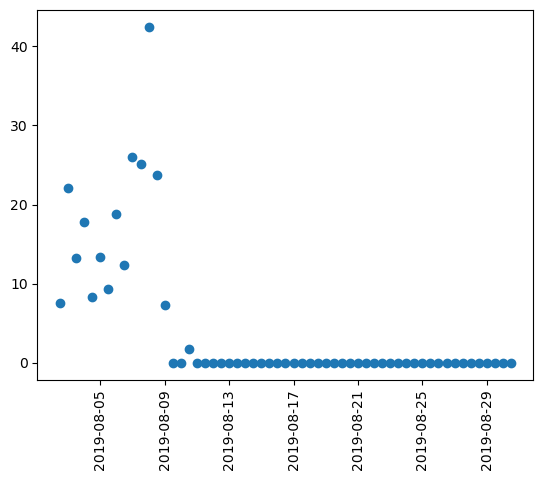

In [22]:
plt.scatter(gdf.t, gdf.flinelen)
plt.xticks(rotation = 90)
plt.show()

# Merge two timeseries

In [23]:
# Reformat station
dat = get_st(lat = cls_st["Lat"], lon = cls_st["Lon"], stations = stations)
dat

/tmp/ipykernel_10819/3206866601.py:7: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)


YYYY  MM  DD  HH   TEMP_C  RH_PERC   VPD_HPA  WDSPD_KPH  PREC_MM  \
0       1999  12  31  16      NaN      NaN       NaN        NaN      NaN   
1       1999  12  31  17  -3.9000   92.056   0.36515     9.3600      0.5   
2       1999  12  31  18  -3.9000   92.056   0.36515     7.5600      0.8   
3       1999  12  31  19  -3.9991   92.958   0.32125     9.4261      0.0   
4       1999  12  31  20  -3.8939   96.400   0.16562     9.3594      0.0   
...      ...  ..  ..  ..      ...      ...       ...        ...      ...   
199251  2022   9  23  19  16.5900   39.621  11.41100     9.4947      0.0   
199252  2022   9  23  20  16.0410   40.909  10.78600     9.7711      0.0   
199253  2022   9  23  21  15.5650   40.429  10.54100    10.0610      0.0   
199254  2022   9  23  22  14.8090   42.626   9.68940     0.2388      0.0   
199255  2022   9  23  23  12.5600   49.194   7.38380    14.6540      0.0   

         SNOWD_M  ...  BUI     ISI     FWI  OBSMINUTEDIFFTEMP  \
0            NaN  ...  NaN     NaN     NaN                NaN   
1       0.080000  ...  NaN     NaN     NaN                0.0   
2       0.000000  ...  NaN     NaN     NaN                0.0   
3       0.000977  ...  NaN     NaN     NaN                4.0   
4       0.000000  ...  NaN     NaN     NaN                4.0   
...          ...  ...  ...     ...     ...                ...   
199251  0.000000  ...  NaN  5.2757  26.060                7.0   
199252  0.000000  ...  NaN  5.3688  26.377                7.0   
199253  0.000000  ...  NaN  5.4656  26.704                7.0   
199254  0.000000  ...  NaN  3.3319  18.791                7.0   
199255  0.000000  ...  NaN  6.8489  31.135                7.0   

        OBSMINUTEDIFFRH  OBSMINUTEDIFFWDSPD  OBSMINUTEDIFFPREC  \
0                   NaN                 NaN                 60   
1                   0.0                 0.0                  0   
2                   0.0                 0.0                  0   
3                   4.0                 4.0                  4   
4                   4.0                 4.0                  4   
...                 ...                 ...                ...   
199251              7.0                 7.0                  7   
199252              7.0                 7.0                  7   
199253              7.0                 7.0                  7   
199254              7.0                 7.0                  7   
199255              7.0                 7.0                  7   

        OBSMINUTEDIFFSNOW  HH_format                time  
0                     NaN         16 1999-12-31 16:00:00  
1                     NaN         17 1999-12-31 17:00:00  
2                     NaN         18 1999-12-31 18:00:00  
3                     NaN         19 1999-12-31 19:00:00  
4                     NaN         20 1999-12-31 20:00:00  
...                   ...        ...                 ...  
199251                NaN         19 2022-09-23 19:00:00  
199252                NaN         20 2022-09-23 20:00:00  
199253                NaN         21 2022-09-23 21:00:00  
199254                NaN         22 2022-09-23 22:00:00  
199255                NaN         23 2022-09-23 23:00:00  

[199256 rows x 23 columns]

In [24]:
#st = stations.loc[(stations.Lat == cls_st["Lat"]) & (stations.Lon == cls_st["Lon"])]
#dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)#
#
#mask = dat['OBSMINUTEDIFFTEMP'].loc[dat.OBSMINUTEDIFFTEMP > 20]  ## Kluge. Basically, use this as a flag. 
#dat.iloc[mask.index, 5:-4 ] = np.nan
#        
#
#times = np.arange(np.datetime64('2000-01-01 12:00:00'),
#                          np.datetime64('2022-09-24 20:00:00'), np.timedelta64(60, 'm')) # Generate timesereis on fly bc parsing files headache # Time shifted????
#dat["time"] = times

In [25]:
# Subset station timeseries because it's way longer than the fire timeseries

st_dat = dat[(dat.time >= min(gdf.t)) &  (dat.time <= max(gdf.t))]
st_dat = st_dat.rename(columns = {"time":"t"})

In [26]:
#print(gdf.columns)
#print(st_dat.columns)
full = pd.merge(gdf,st_dat, on = "t", how = "outer")
full = full.sort_values(by = ['t']) ## Need to sort or timeseries jumps around 


def fr_st_merge(gdf, dat, sub= True):
    if(sub):
        st_dat = dat[(dat.time >= min(gdf.t)) &  (dat.time <= max(gdf.t))]
        st_dat = st_dat.rename(columns = {"time":"t"})
    else:
        st_dat = dat
            
    full = pd.merge(gdf,st_dat, on = "t", how = "outer")
    full = full.sort_values(by = ['t']) ## Need to sort or timeseries jumps around
    full['t'] = full['t'].astype('datetime64[ns]') 
    return(full)


full.columns

Index(['n_pixels', 'n_newpixels', 'farea', 'fperim', 'flinelen', 'duration',
       'pixden', 'meanFRP', 't', 'geometry', 'YYYY', 'MM', 'DD', 'HH',
       'TEMP_C', 'RH_PERC', ' VPD_HPA', 'WDSPD_KPH', 'PREC_MM', 'SNOWD_M',
       'FFMC', 'DMC', 'DC', 'BUI', 'ISI', 'FWI', 'OBSMINUTEDIFFTEMP',
       'OBSMINUTEDIFFRH', 'OBSMINUTEDIFFWDSPD', 'OBSMINUTEDIFFPREC',
       'OBSMINUTEDIFFSNOW', 'HH_format'],
      dtype='object')

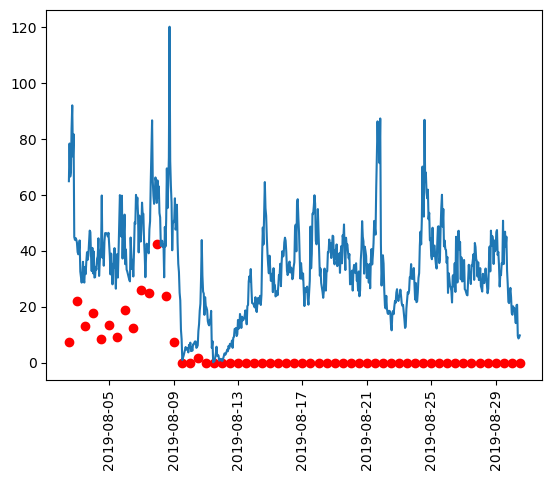

In [27]:
# Try plotting this

full['t'] = full['t'].astype('datetime64[ns]') ## Some type error????
#full['t'] = full['t'].astype('str')

plt.scatter(full.t, full.flinelen, color = "r")
plt.plot(full.t, full.FWI)
plt.xticks(rotation = 90)
plt.show()

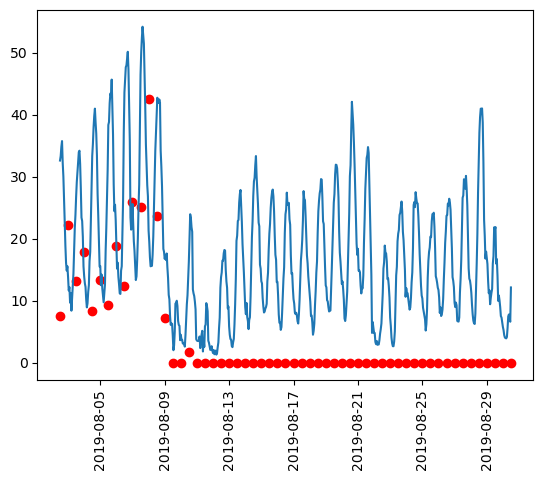

In [28]:
# Try plotting this

full['t'] = full['t'].astype('datetime64[ns]') ## Some type error????
#full['t'] = full['t'].astype('str')

plt.scatter(full.t, full.flinelen, color = "r")
plt.plot(full.t, full[' VPD_HPA'])
plt.xticks(rotation = 90)
plt.show()

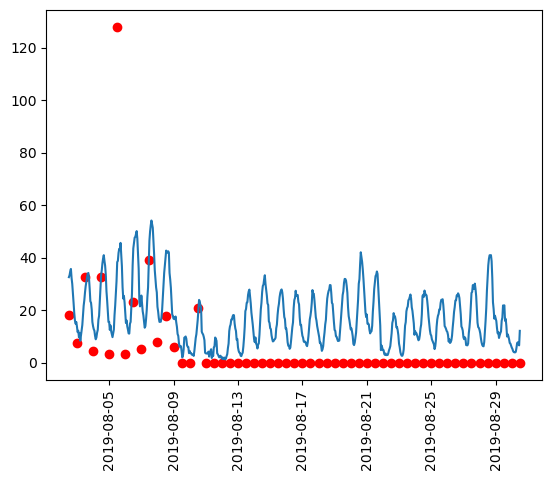

In [29]:
# Try plotting this

full['t'] = full['t'].astype('datetime64[ns]') ## Some type error????
#full['t'] = full['t'].astype('str')

plt.scatter(full.t, full.meanFRP, color = "r")
plt.plot(full.t, full[' VPD_HPA'])
plt.xticks(rotation = 90)
plt.show()

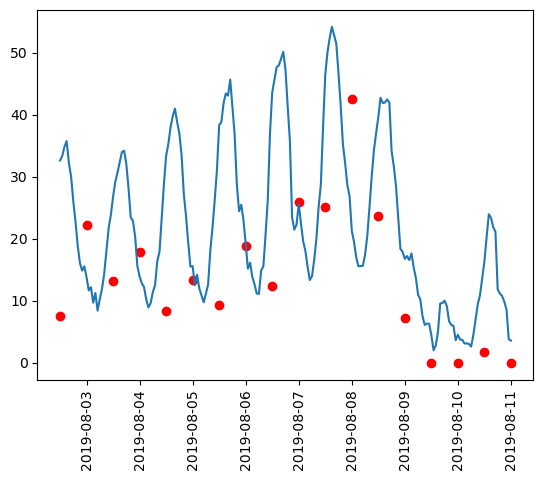

In [30]:
## Look at just the fire timeline


full_fr = full[(full.t >= min(full.t)) &  (full.t <= "2019-08-11")]

plt.scatter(full_fr.t, full_fr.flinelen, color = "r")
plt.plot(full_fr.t, full_fr[' VPD_HPA'])
plt.xticks(rotation = 90)
plt.show()


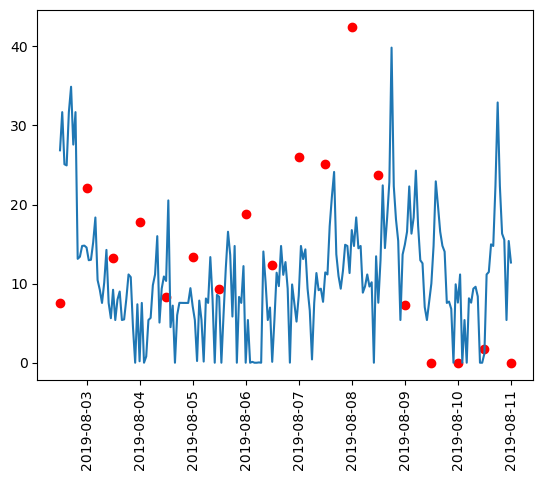

In [31]:

plt.scatter(full_fr.t, full_fr.flinelen, color = "r")
plt.plot(full_fr.t, full_fr['WDSPD_KPH'])
plt.xticks(rotation = 90)
plt.show()


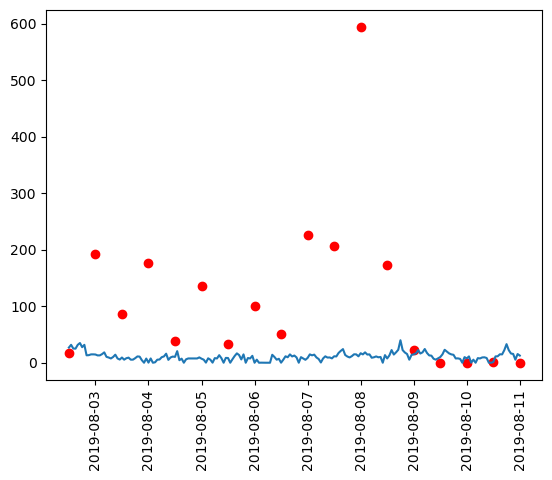

In [32]:


plt.scatter(full_fr.t, full_fr.n_newpixels, color = "r")
plt.plot(full_fr.t, full_fr['WDSPD_KPH'])
plt.xticks(rotation = 90)
plt.show()

# Plot exploratory variables all at once

'n_pixels', 'n_newpixels', 'farea', 'fperim', 'flinelen', 'duration',
       'pixden', 'meanFRP', 't', 'geometry', 'YYYY', 'MM', 'DD', 'HH',
       'TEMP_C', 'RH_PERC', ' VPD_HPA', 'WDSPD_KPH', 'PREC_MM', 'SNOWD_M',
       'FFMC', 'DMC', 'DC', 'BUI', 'ISI', 'FWI', 'OBSMINUTEDIFFTEMP',
       'OBSMINUTEDIFFRH', 'OBSMINUTEDIFFWDSPD', 'OBSMINUTEDIFFPREC',
       'OBSMINUTEDIFFSNOW', 'HH_format'],
      dtype='object'

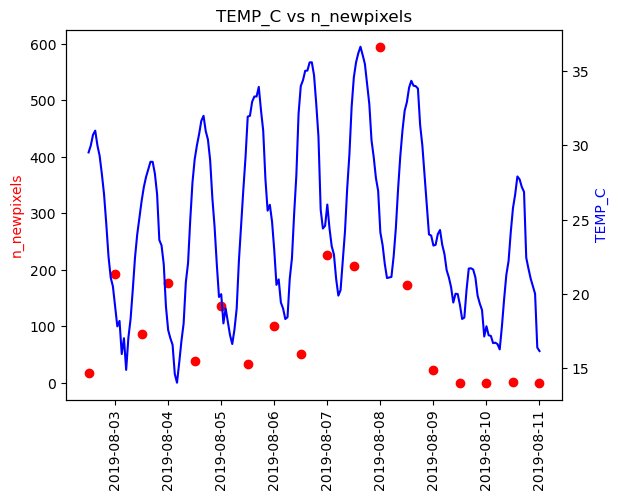

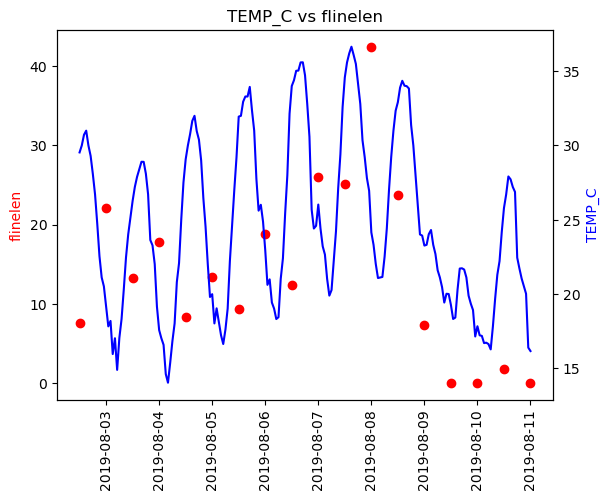

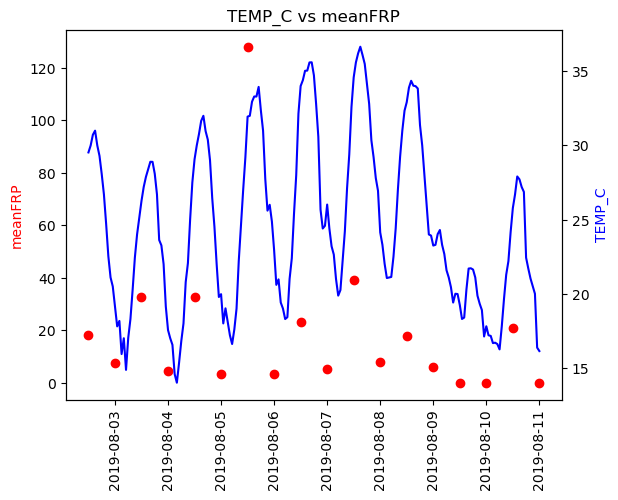

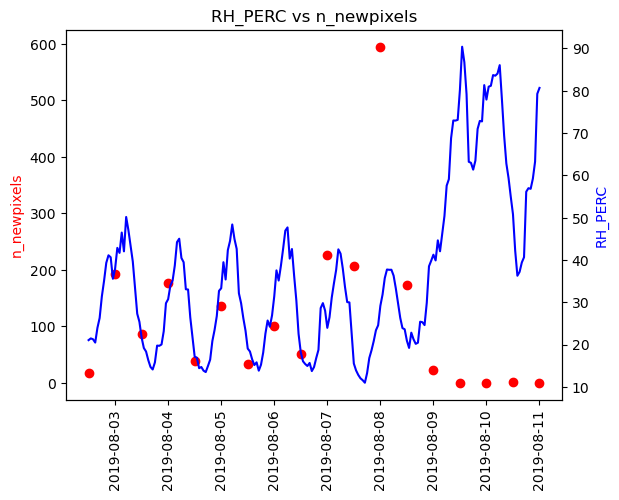

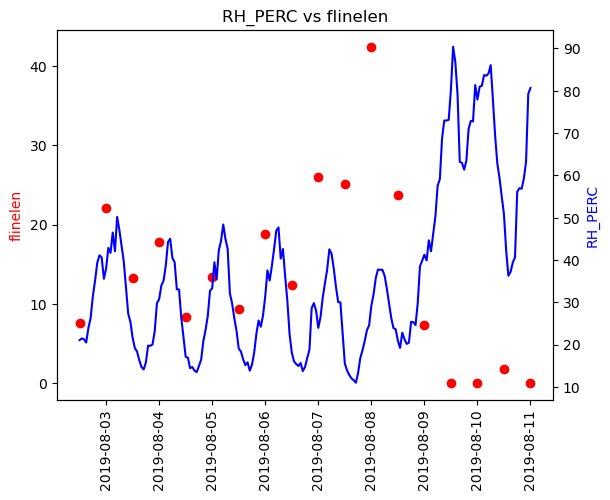

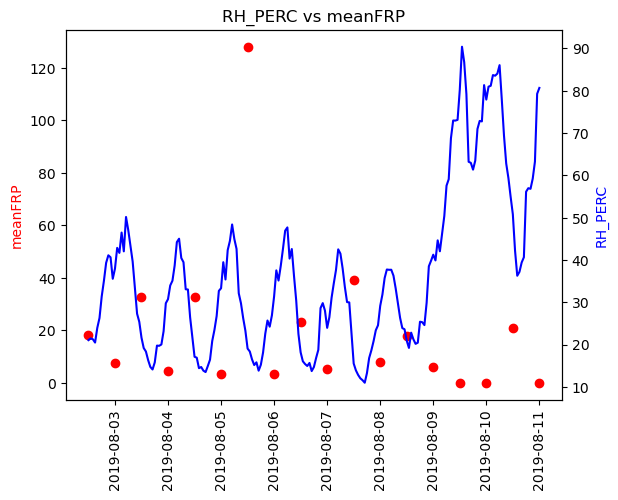

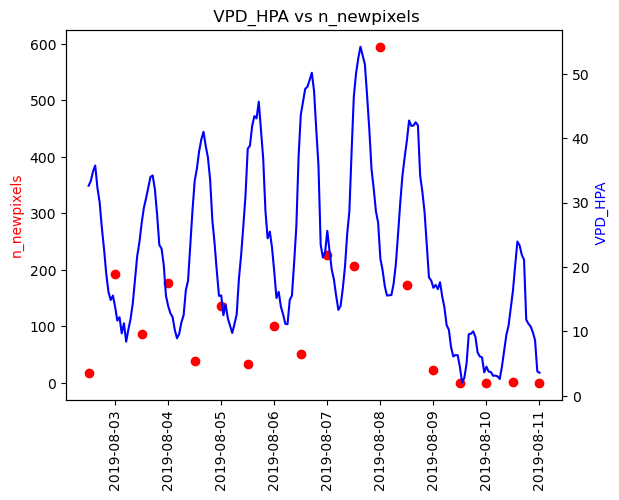

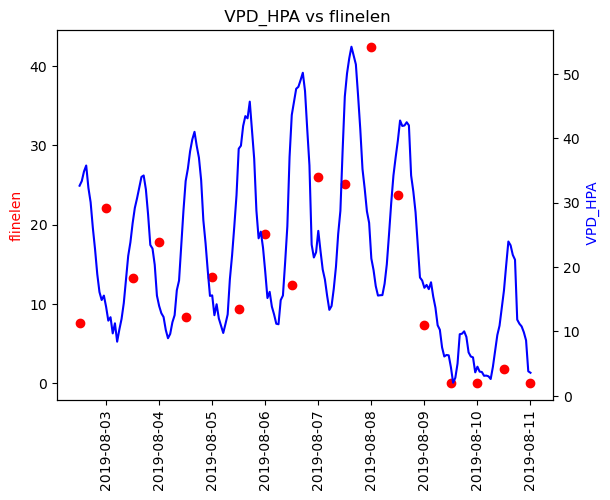

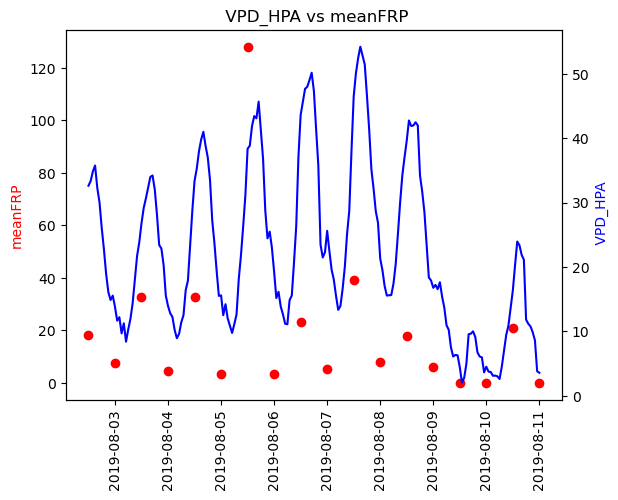

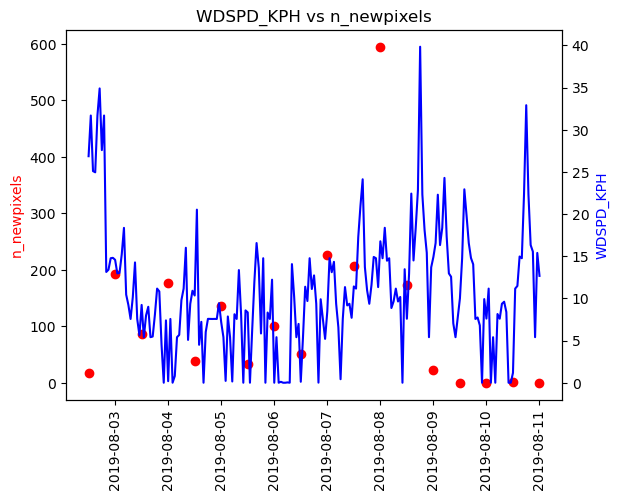

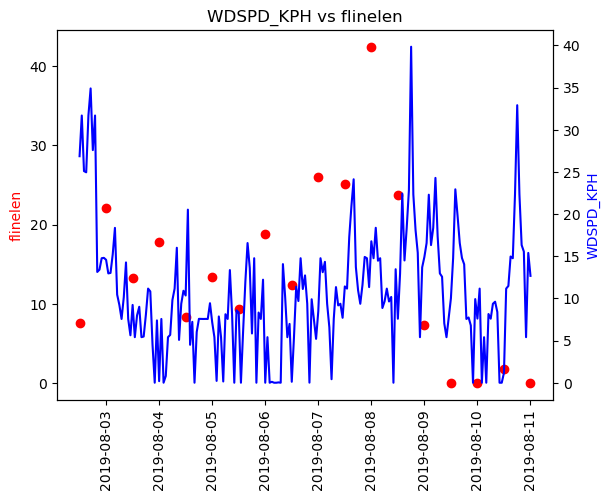

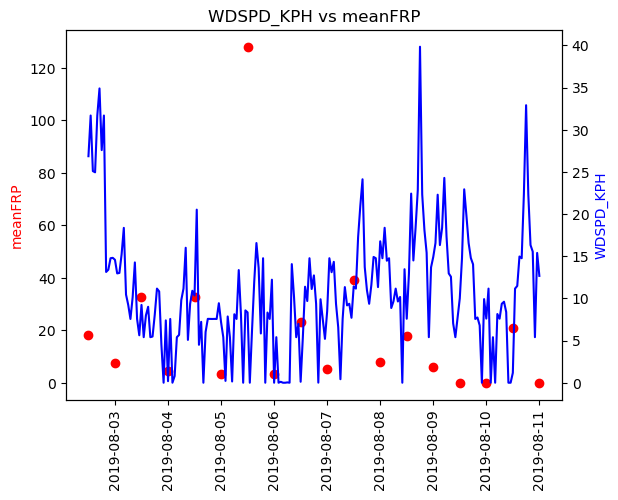

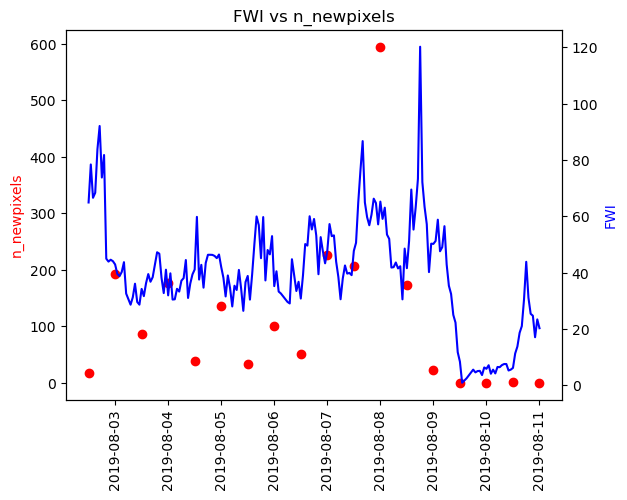

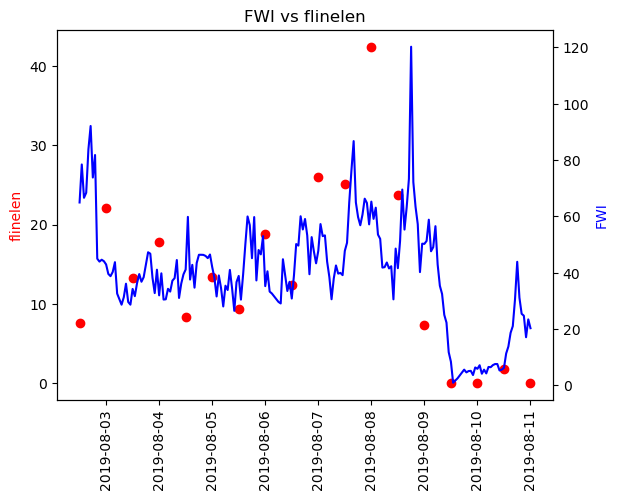

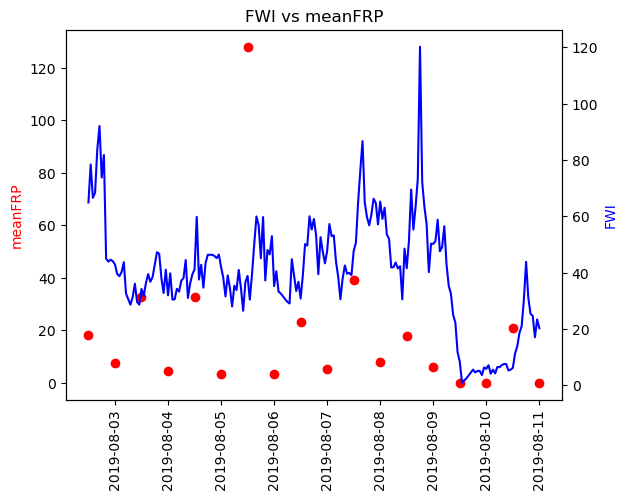

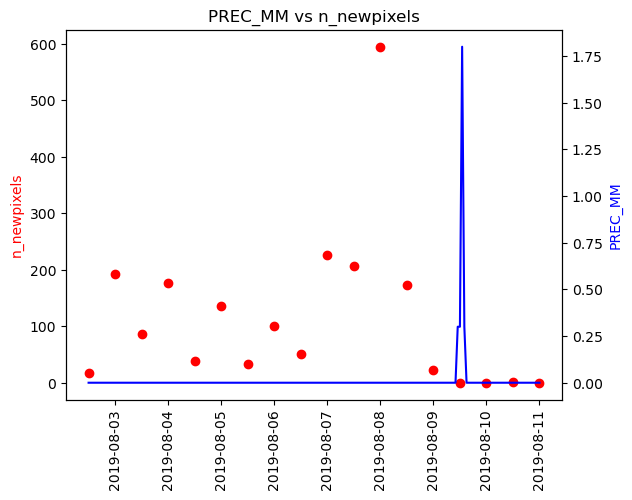

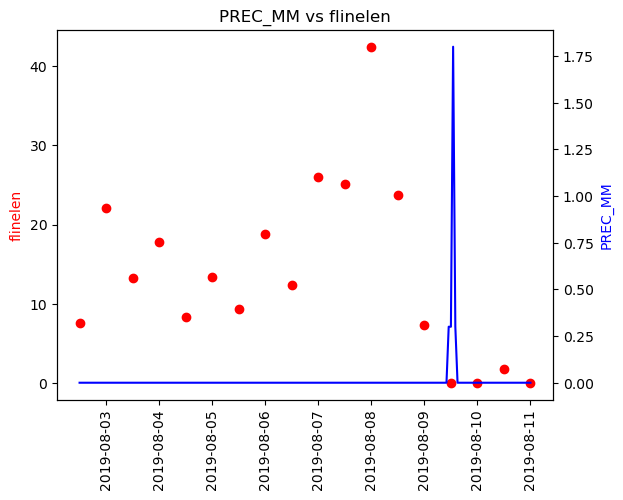

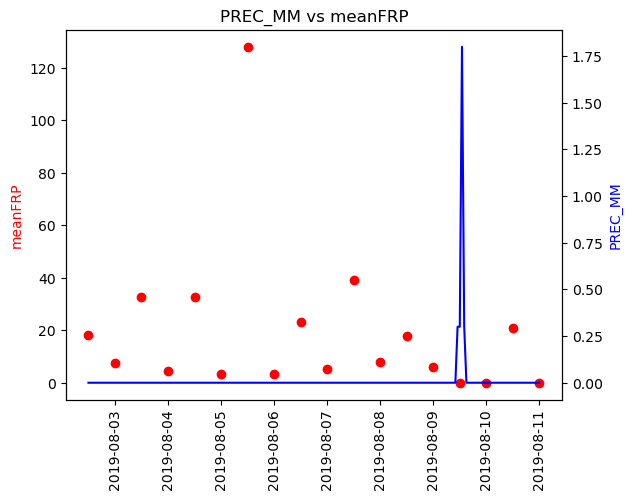

In [33]:

met = ['TEMP_C', 'RH_PERC', ' VPD_HPA', 'WDSPD_KPH',
       'FWI', 'PREC_MM']
fire = [ 'n_newpixels', 'flinelen','meanFRP',]

#n_met = len(met)
#n_fire = len(fire)

for m in met:
    for f in fire:
        fig, ax = plt.subplots()
        
        ax.scatter(full_fr["t"], full_fr[f], color = "r")
        #ax.plot(full_fr["t"], full_fr[m])
        #plt.xticks(rotation = 90)   
        ax.set_title(m + " vs " +  f)
        ax.set_ylabel(f, color = "red")
        ax2=ax.twinx()
        ax2.plot(full_fr["t"], full_fr[m],color="blue")
        ax2.set_ylabel(m,color="blue")
        ax.tick_params(axis='x', labelrotation = 90)

        plt.show()

# Try treating day and night as different

In [34]:
full_fr_i = full_fr
full_fr_i  = full_fr_i.set_index('t')

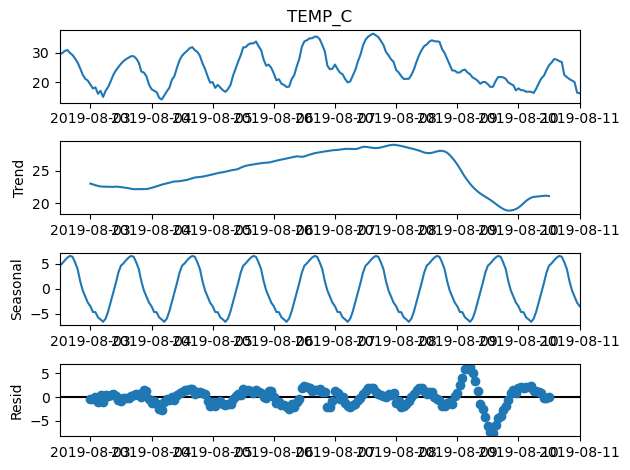

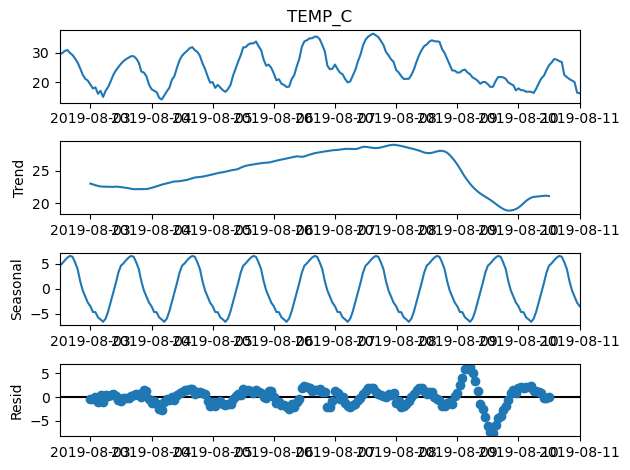

In [35]:
# mamba install statsmodels ## I didn't include this in my stable env yet. Need to see if like it
from statsmodels.tsa.seasonal import seasonal_decompose
#dat_t = get_st(lat = cls_st["Lat"], lon = cls_st["Lon"], stations = stations, flag_bad= False)
#dat_i = dat_t.set_index('time')


#decomp_temp = seasonal_decompose(dat_i.TEMP_C, model="additive")
#decomp_temp.plot()

#plt.plot(decomp_temp.seasonal)

decomp_temp = seasonal_decompose(full_fr_i.TEMP_C, model="additive")
decomp_temp.plot()




(array([18111., 18112., 18113., 18114., 18115., 18116., 18117., 18118.,
        18119.]),
 [Text(18111.0, 0, '2019-08-03'),
  Text(18112.0, 0, '2019-08-04'),
  Text(18113.0, 0, '2019-08-05'),
  Text(18114.0, 0, '2019-08-06'),
  Text(18115.0, 0, '2019-08-07'),
  Text(18116.0, 0, '2019-08-08'),
  Text(18117.0, 0, '2019-08-09'),
  Text(18118.0, 0, '2019-08-10'),
  Text(18119.0, 0, '2019-08-11')])

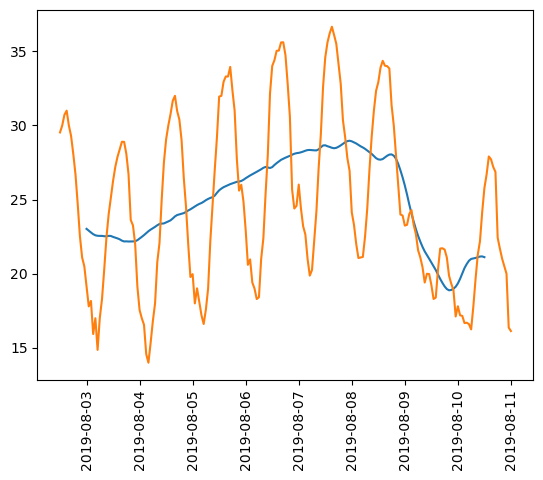

In [36]:
# Be define only the daily cycle. 

#Daily_mean = full_fr_i.TEMP_C.rolling(window = 24).mean()
temp_detrended = full_fr_i.TEMP_C - (decomp_temp.seasonal + decomp_temp.resid)
plt.plot(temp_detrended)
#plt.plot(decomp_temp.resid)
plt.plot(full_fr_i.TEMP_C)
plt.xticks(rotation = 90)

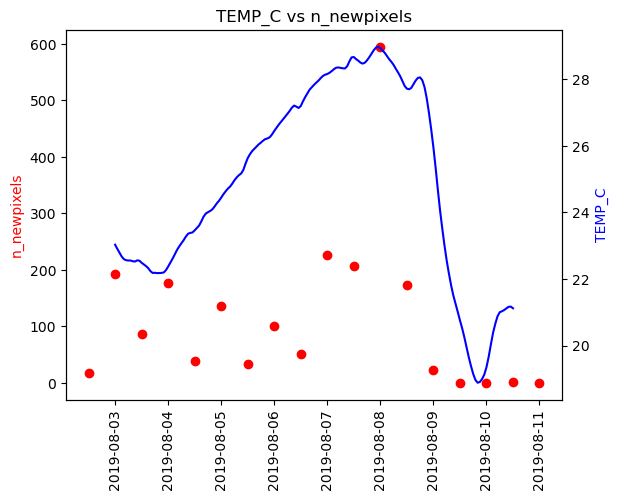

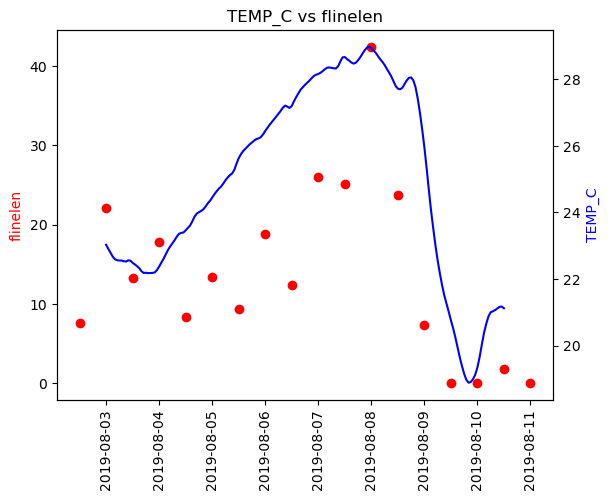

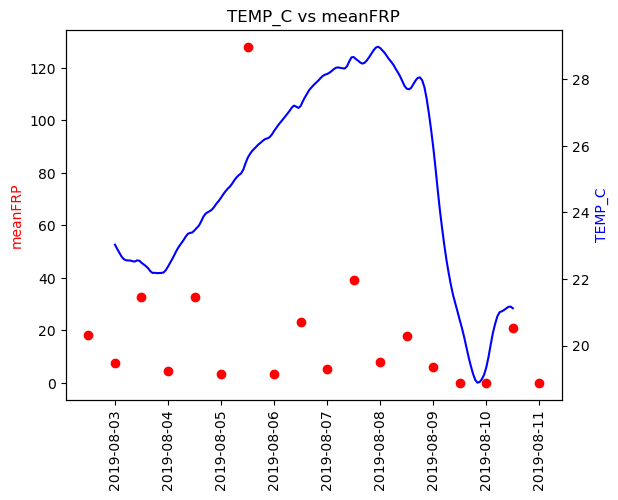

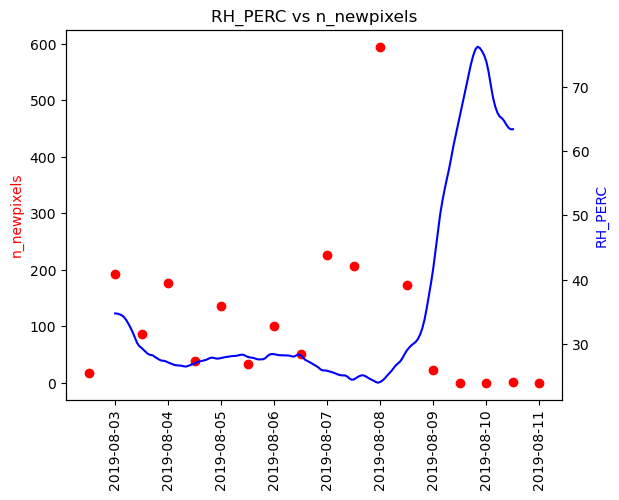

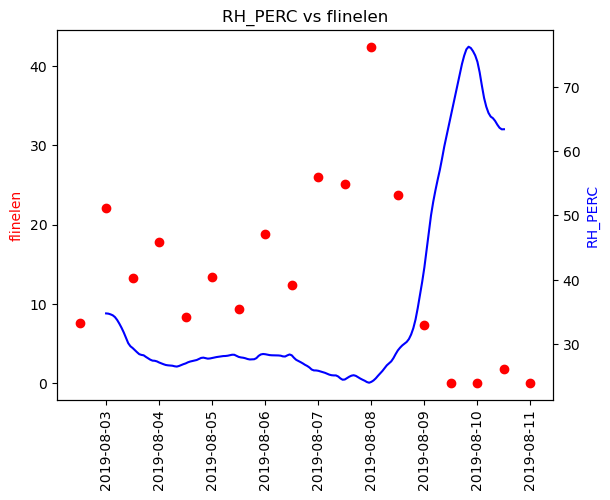

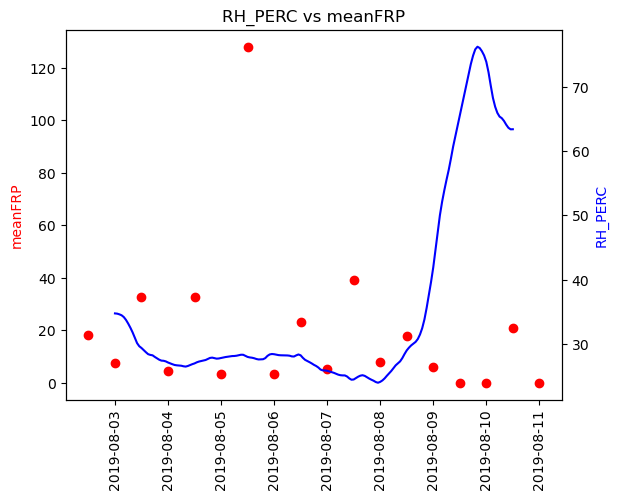

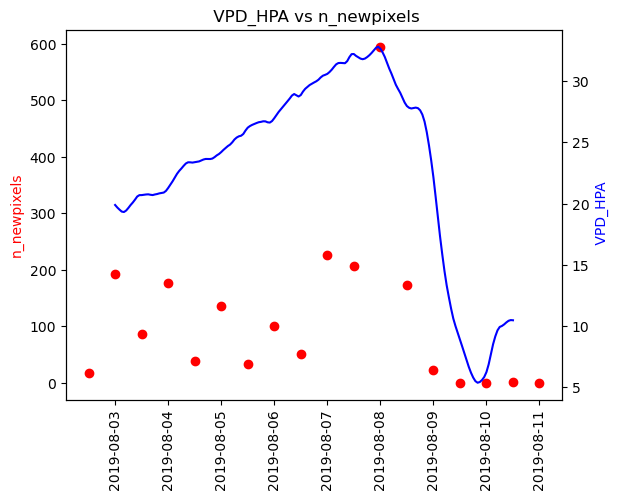

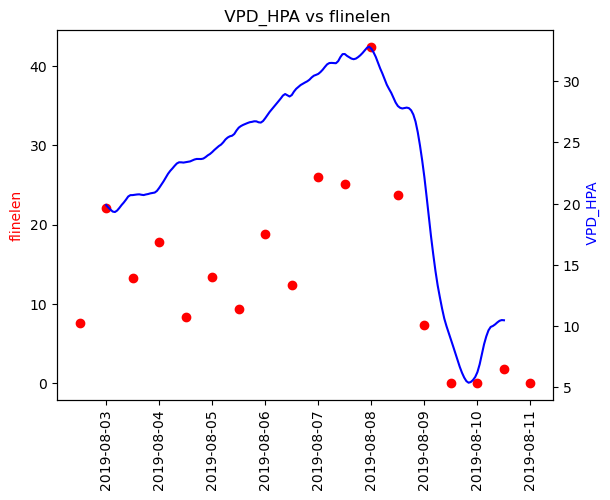

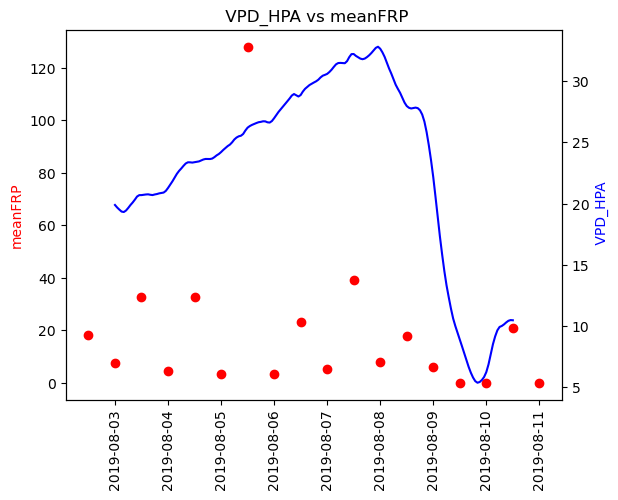

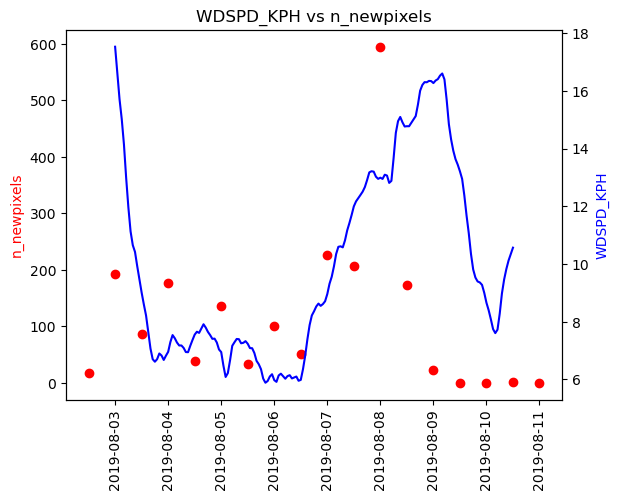

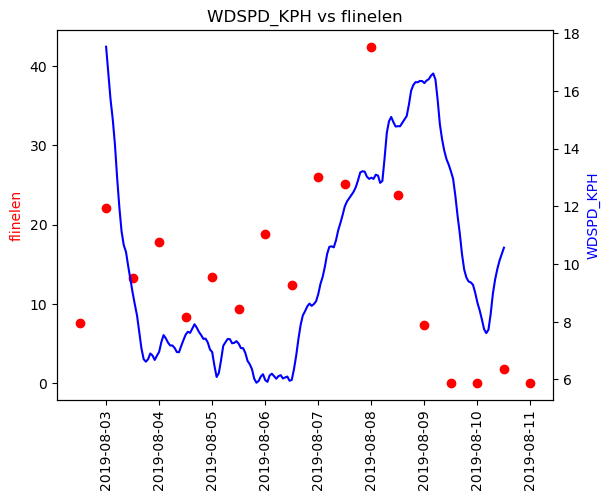

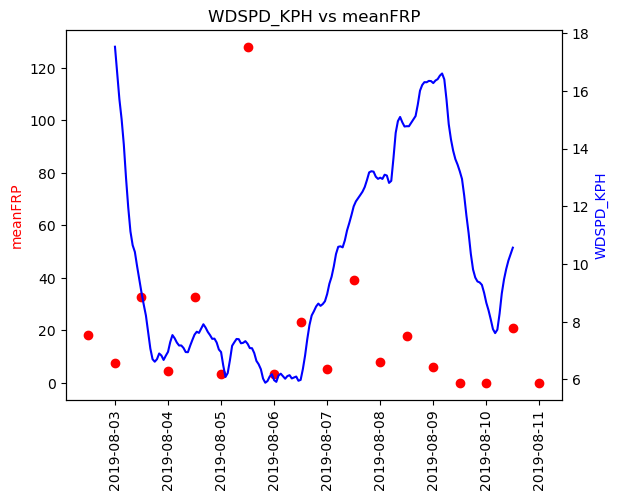

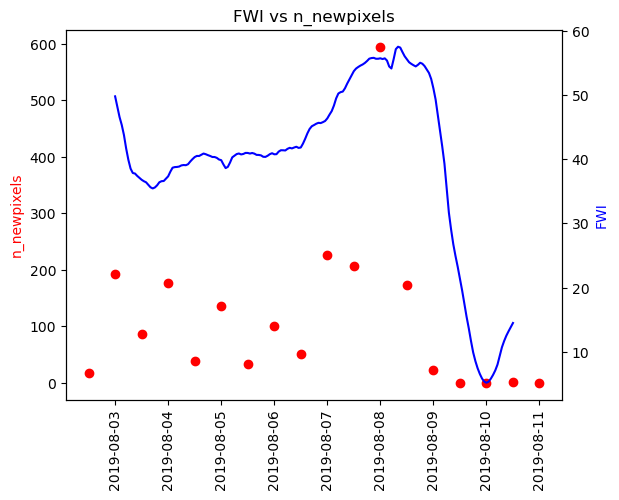

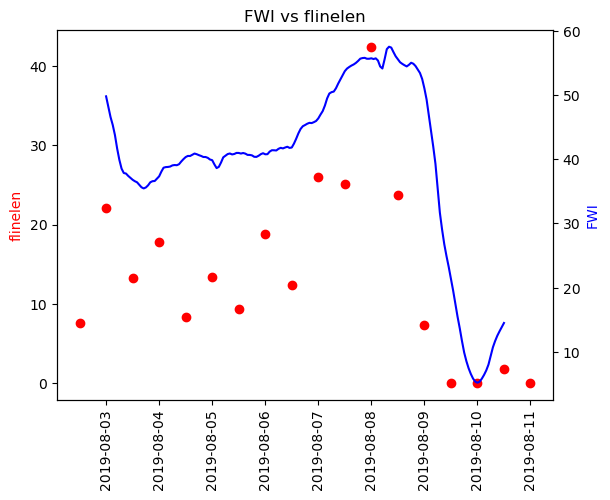

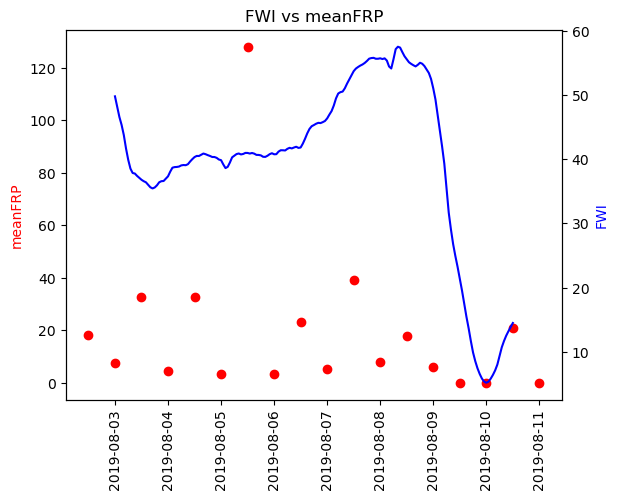

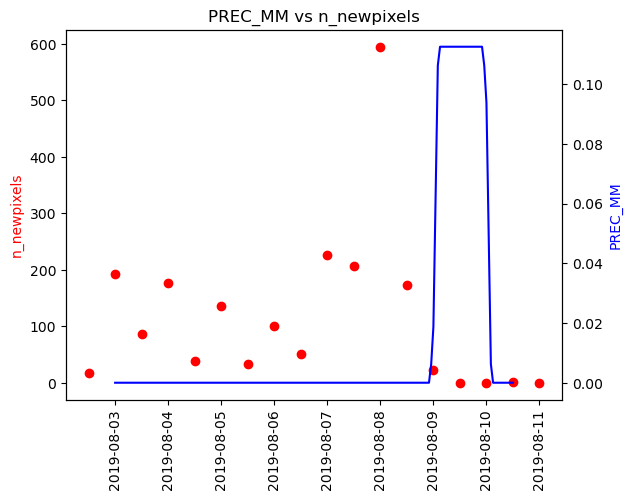

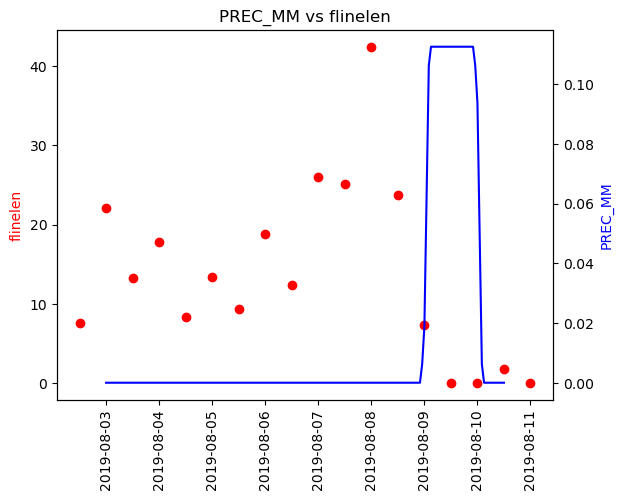

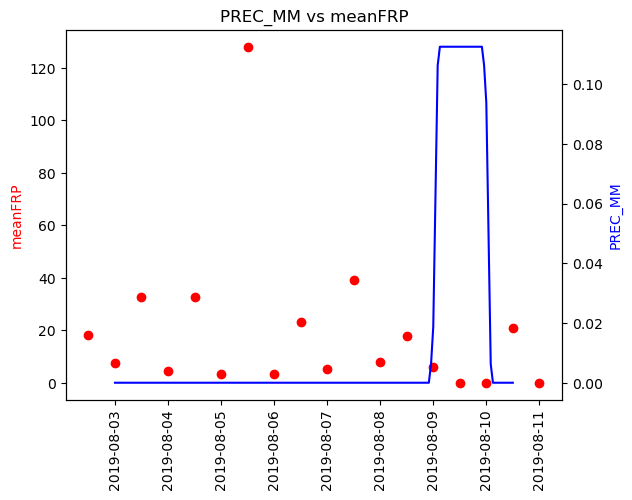

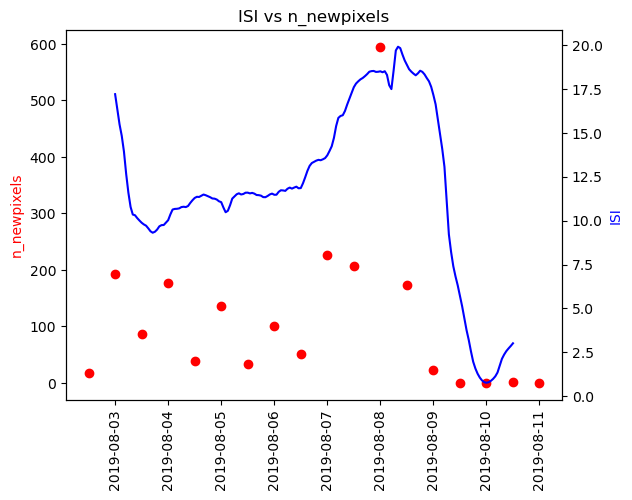

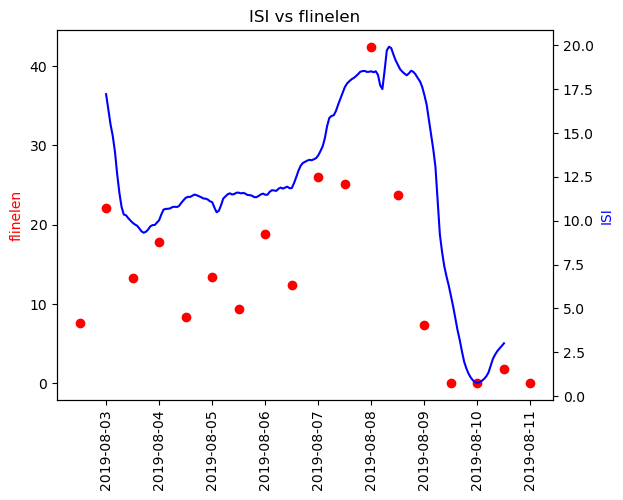

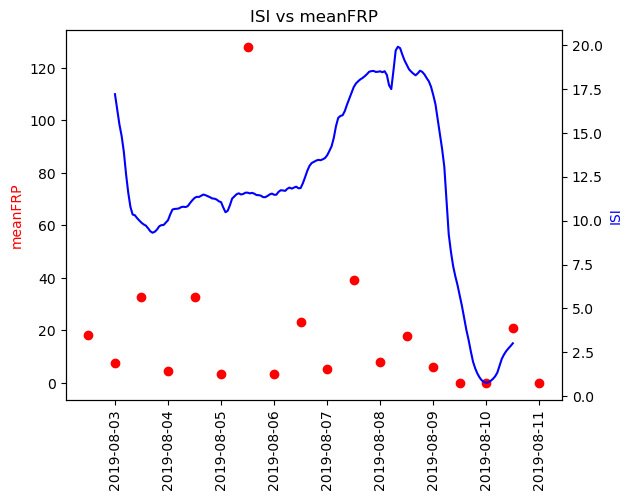

In [37]:
met = ['TEMP_C', 'RH_PERC', ' VPD_HPA', 'WDSPD_KPH',
       'FWI', 'PREC_MM', 'ISI']
fire = [ 'n_newpixels', 'flinelen','meanFRP',]


for m in met:
    met_decomp = seasonal_decompose(full_fr_i[m], model="additive")

    for f in fire:
        fig, ax = plt.subplots()
        
        ax.scatter(full_fr_i.index, full_fr_i[f], color = "r")
        ax.set_title(m + " vs " +  f)
        ax.set_ylabel(f, color = "red")
        ax2=ax.twinx()
        ax2.plot(full_fr_i.index, met_decomp.trend,color="blue")
        ax2.set_ylabel(m,color="blue")
        ax.tick_params(axis='x', labelrotation = 90)

        plt.show()

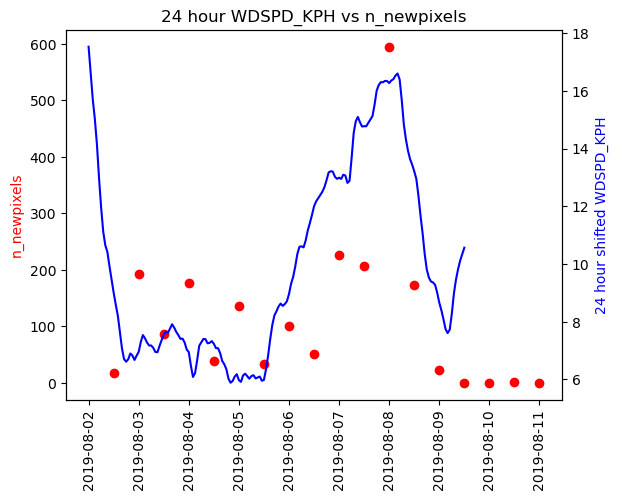

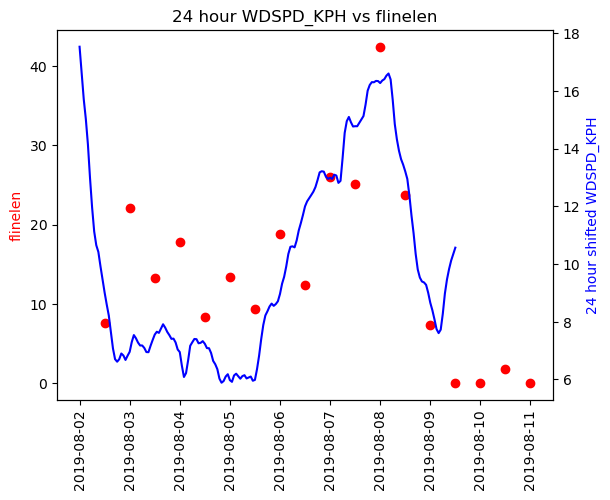

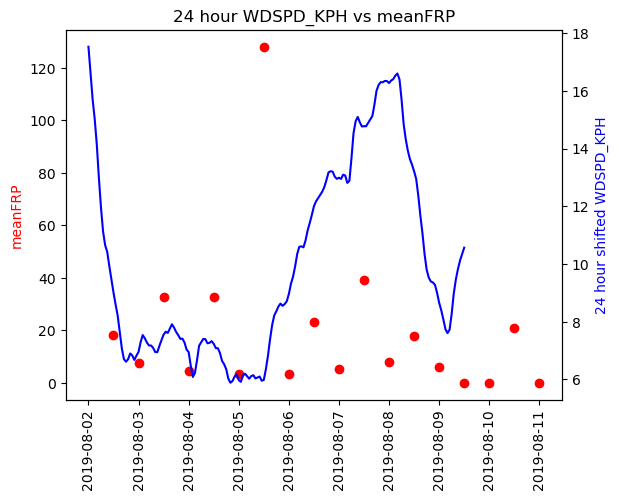

In [117]:
## Checking if windspeed can line up the way I think it can. 

time_diff = pd.Timedelta("24 hours")


met_decomp = seasonal_decompose(full_fr_i['WDSPD_KPH'], model="additive")

for f in fire:
    fig, ax = plt.subplots()
        
    ax.scatter(full_fr_i.index, full_fr_i[f], color = "r")
    ax.set_title('24 hour WDSPD_KPH' + " vs " +  f)
    ax.set_ylabel(f, color = "red")
    ax2=ax.twinx()
    ax2.plot(full_fr_i.index - time_diff, met_decomp.trend,color="blue")
    ax2.set_ylabel('24 hour shifted WDSPD_KPH',color="blue")
    ax.tick_params(axis='x', labelrotation = 90)

    plt.show()

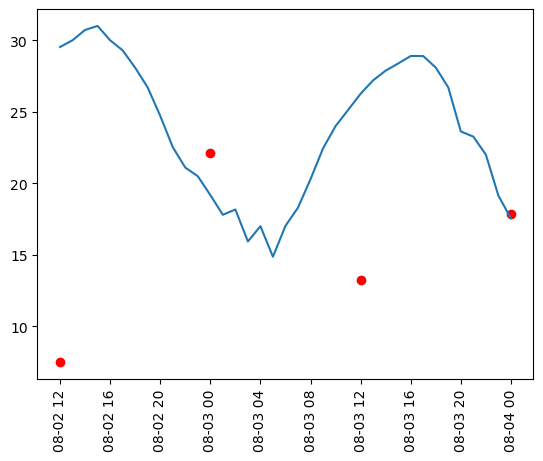

In [126]:

day = full[(full.t >= min(full.t)) &  (full.t <= "2019-08-04")]
plt.scatter(day.t, day.flinelen, color = "r")
plt.plot(day.t, day['TEMP_C'])
plt.xticks(rotation = 90)
plt.show()

## Taboose Fire Incident

In [179]:
# Find the closest station
foi = {'Lat':37.018, 'Lon': -118.302} ## Centriod of Taboose Fire Incident
st_dict = stations[['Lat', 'Lon']].to_dict('records') # Makes transform
cls_st = closest(st_dict, foi) ## Different rounding than DF value if printed!!!!
print(cls_st) ## About 35 miles away
#Plot variables # Looks like there are more missing data. Also, large swings in temp? Should be thinking better about elevation? 
#plot_st(lat = cls_st["Lat"], lon = cls_st["Lon"], 
#        stations = stations, 
#        time_start = '2019-09-05 01:00:00',  ## Aproximate duration of fire from snapshot. Calfimre says was contained Nov 21st 
#        time_end = '2019-09-19 23:00:00')

{'Lat': 37.371, 'Lon': -118.359}


In [178]:
lf_files = glob.glob('/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2019/Largefire/*6388*') ## ID of William's Flats

# unique lf ids if more than one, but works with only one too!
lf_ids = list(set([file.split('Largefire/')[1].split('_')[0] for file in lf_files])) 
print('Number of LF ids:',len(lf_ids)) # Should be one, just william's flats


largefire_dict = dict.fromkeys(lf_ids)
for lf_id in lf_ids:
    most_recent_file = [file for file in lf_files if lf_id in file][-1]
    largefire_dict[lf_id] = most_recent_file
    
gdf = pd.concat([gpd.read_file(file,layer='perimeter') for key, file in largefire_dict.items()], 
                   ignore_index=True)
gdf = gdf.sort_values(by = ['t'])
#gdf
  

Number of LF ids: 1


In [181]:
                 
dat = get_st(lat = cls_st["Lat"], lon = cls_st["Lon"], stations = stations, flag_bad= False)
#dat

/tmp/ipykernel_2875/3206866601.py:7: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  dat = pd.read_csv(("s3://" + st.File_path.iloc[0]), index_col = False)


In [182]:
st_dat = dat[(dat.time >= min(gdf.t)) &  (dat.time <= max(gdf.t))]
st_dat = st_dat.rename(columns = {"time":"t"})
#st_dat

In [183]:
#print(gdf.columns)
#print(st_dat.columns)
full = pd.merge(gdf,st_dat, on = "t", how = "outer")
full = full.sort_values(by = ['t']) ## Need to sort or timeseries jumps around 
print(full.columns)
#full

Index(['n_pixels', 'n_newpixels', 'farea', 'fperim', 'flinelen', 'duration',
       'pixden', 'meanFRP', 't', 'geometry', 'YYYY', 'MM', 'DD', 'HH',
       'TEMP_C', 'RH_PERC', ' VPD_HPA', 'WDSPD_KPH', 'PREC_MM', 'SNOWD_M',
       'FFMC', 'DMC', 'DC', 'BUI', 'ISI', 'FWI', 'OBSMINUTEDIFFTEMP',
       'OBSMINUTEDIFFRH', 'OBSMINUTEDIFFWDSPD', 'OBSMINUTEDIFFPREC',
       'OBSMINUTEDIFFSNOW', 'HH_format'],
      dtype='object')


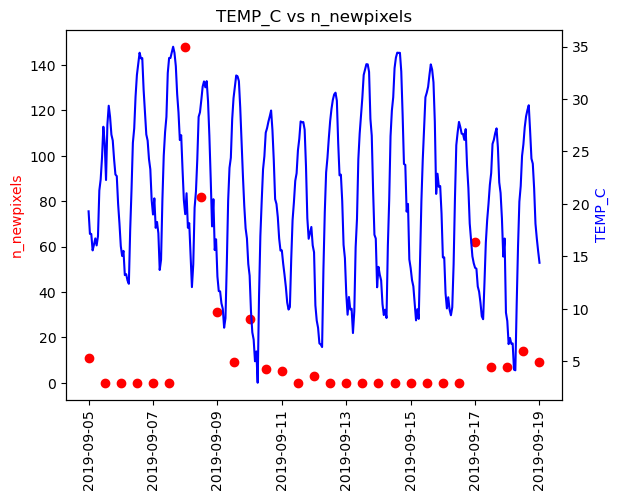

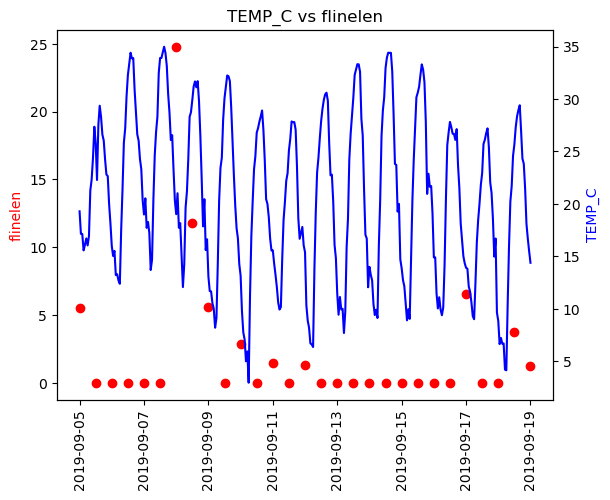

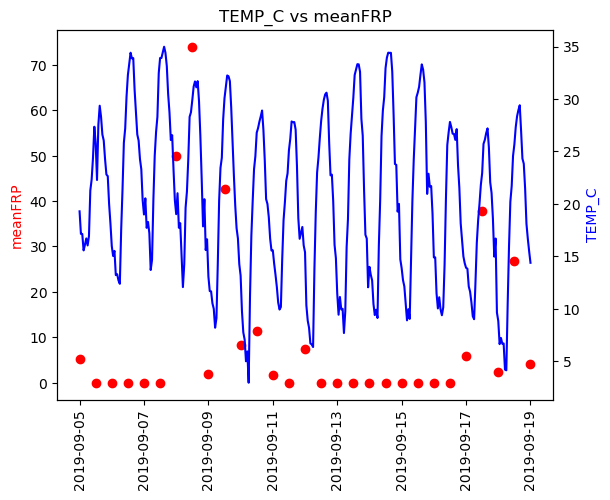

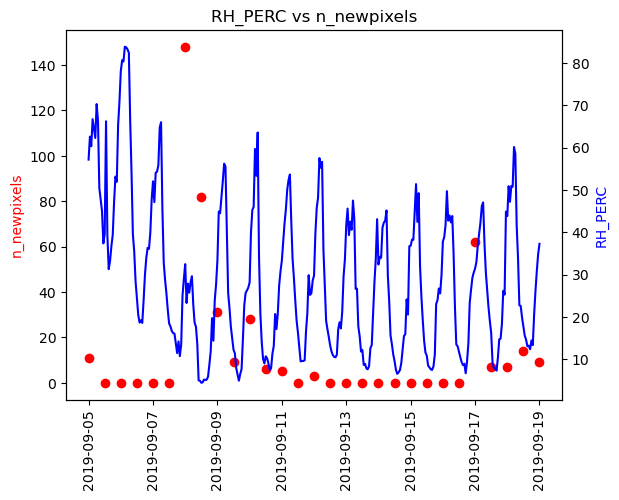

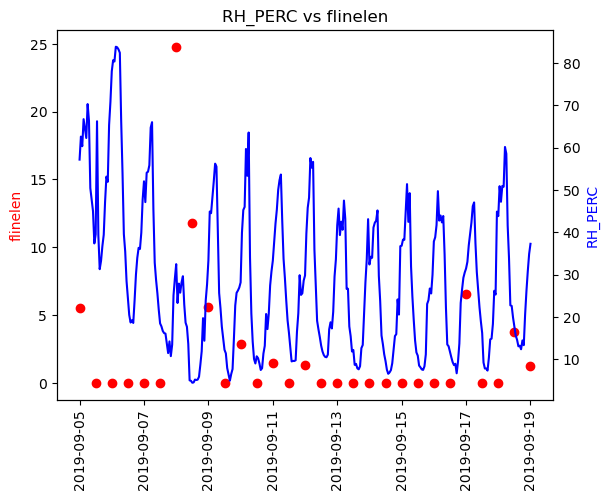

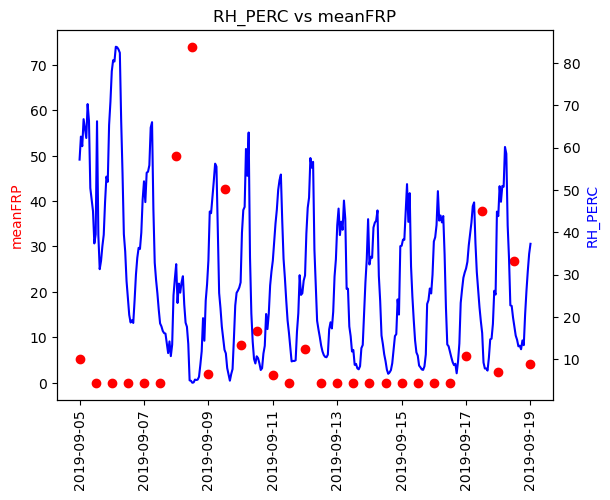

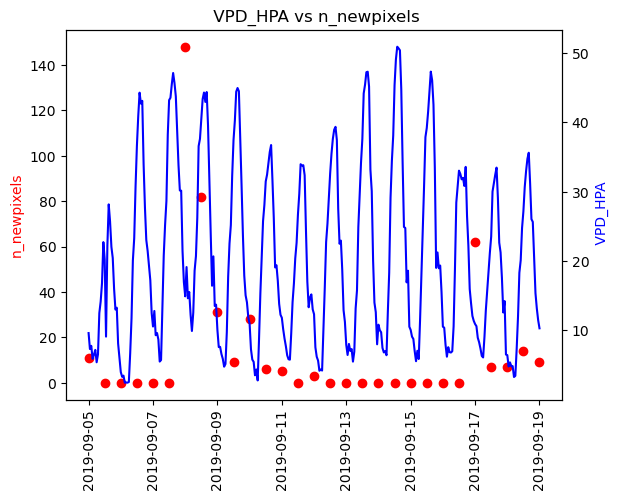

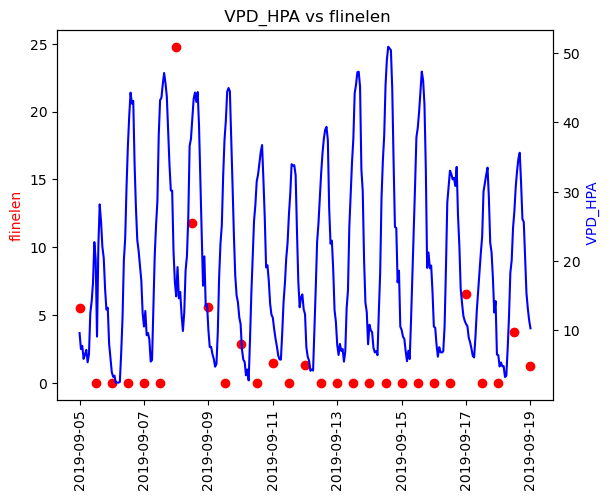

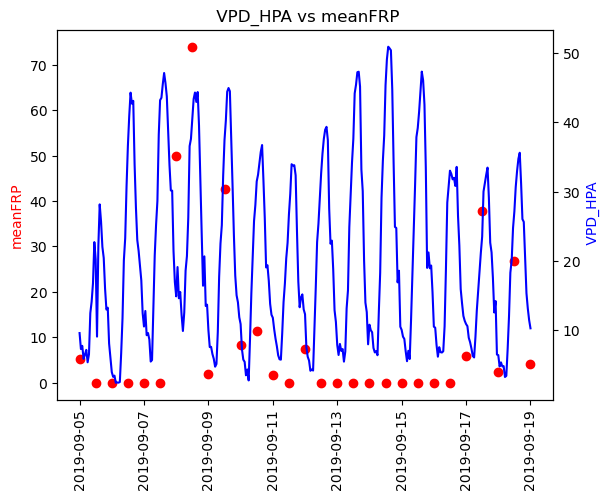

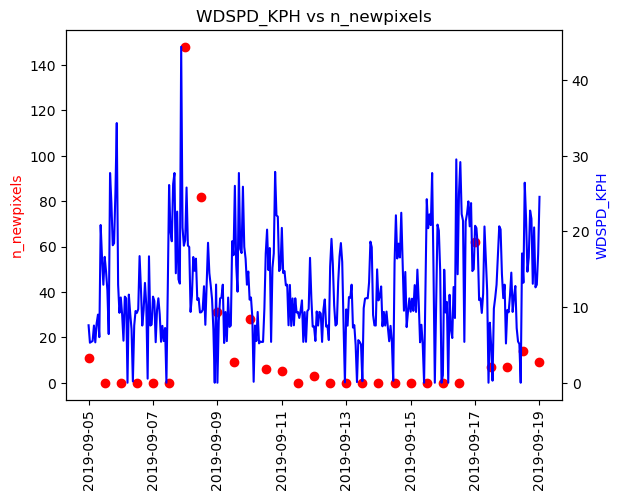

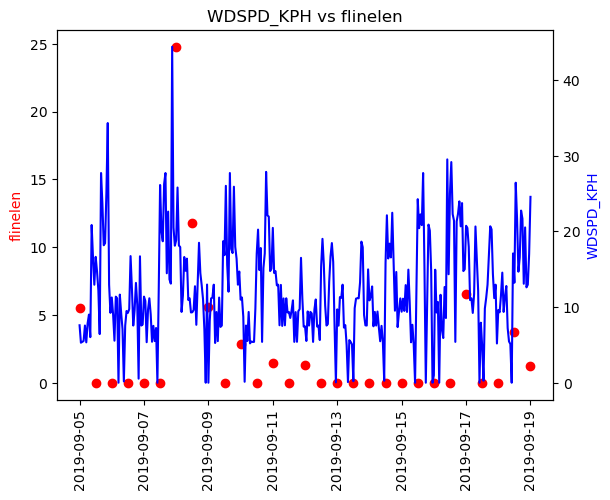

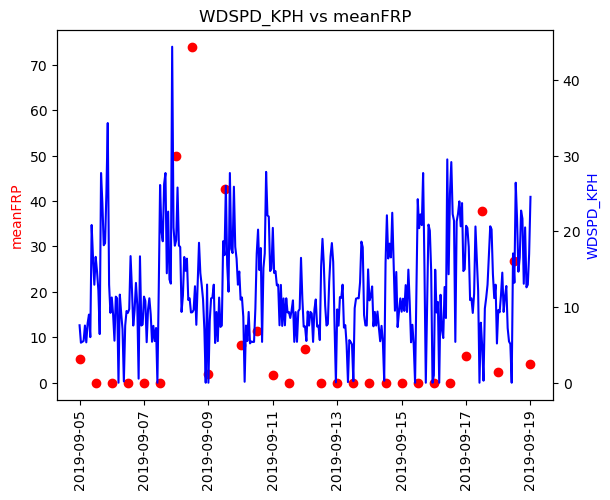

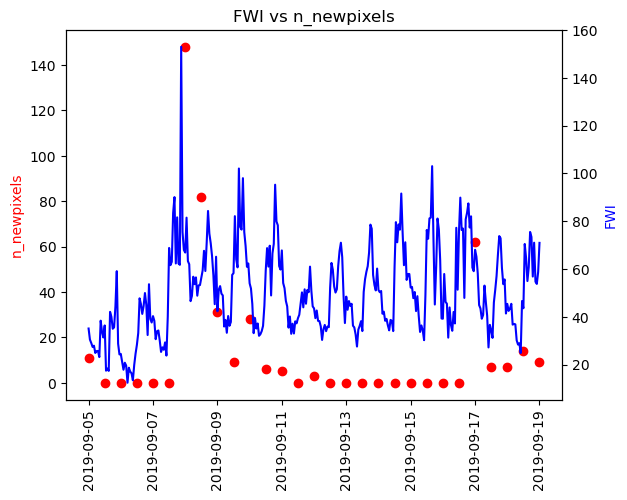

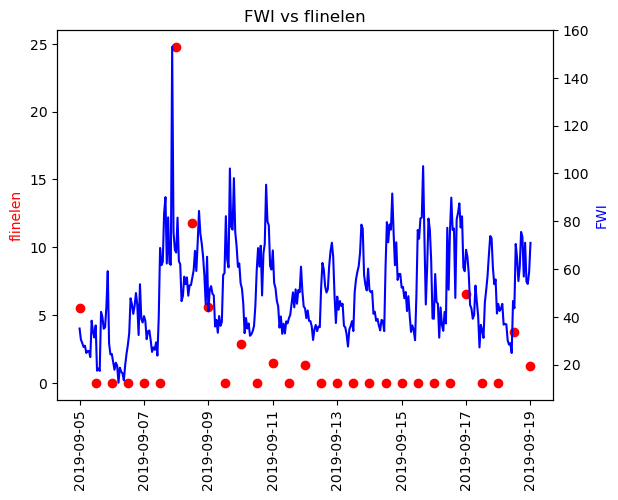

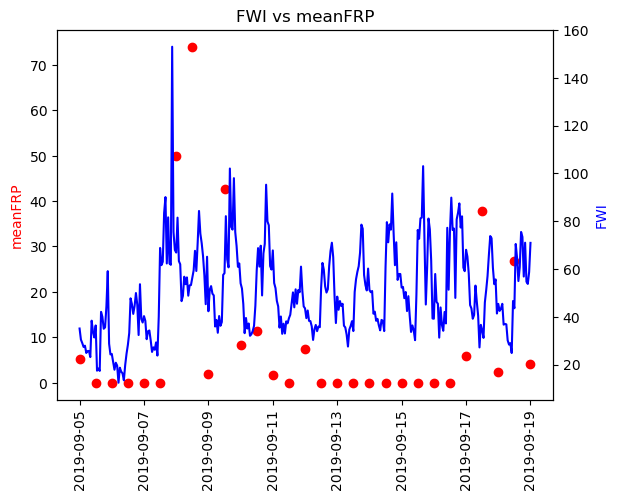

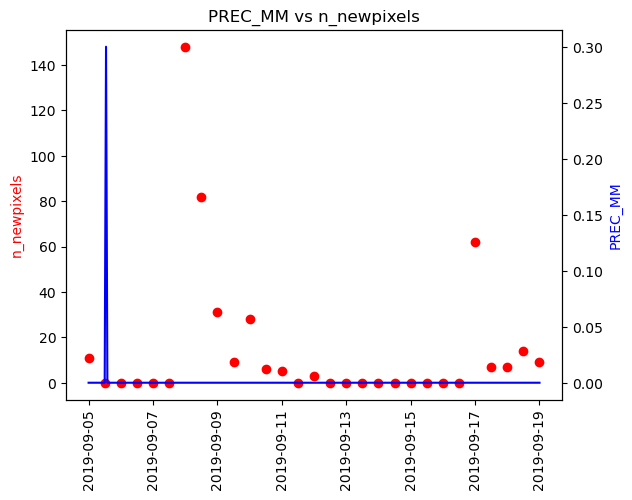

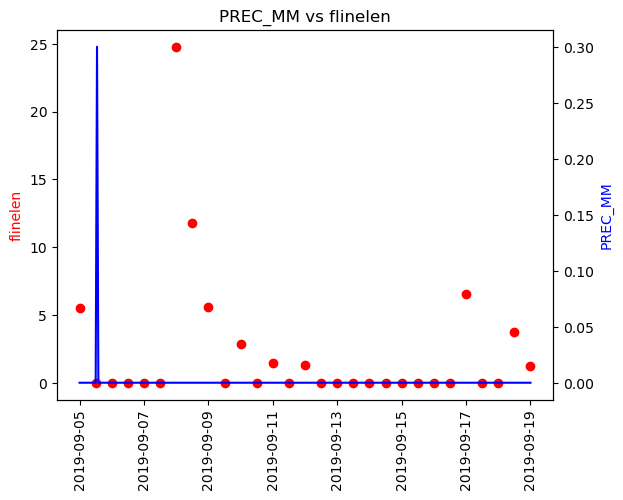

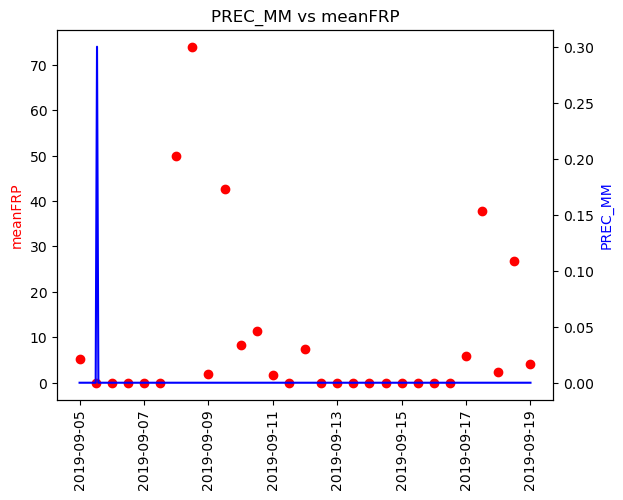

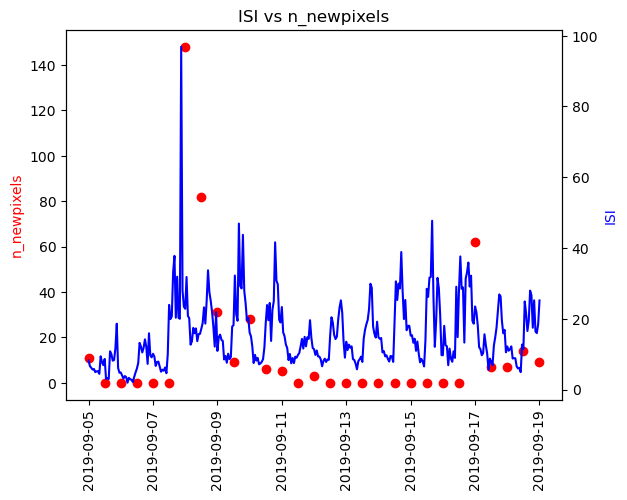

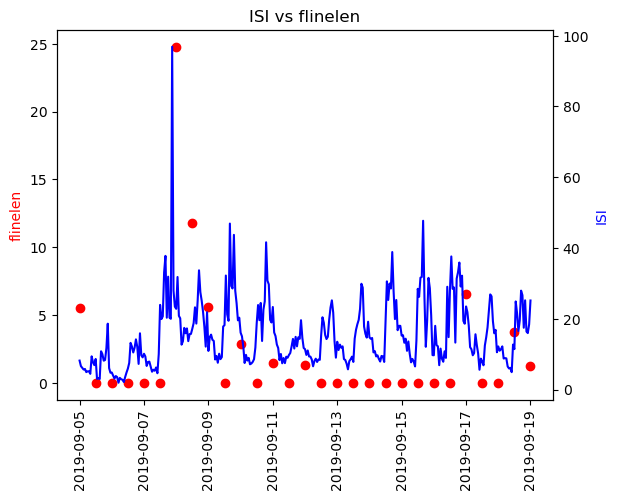

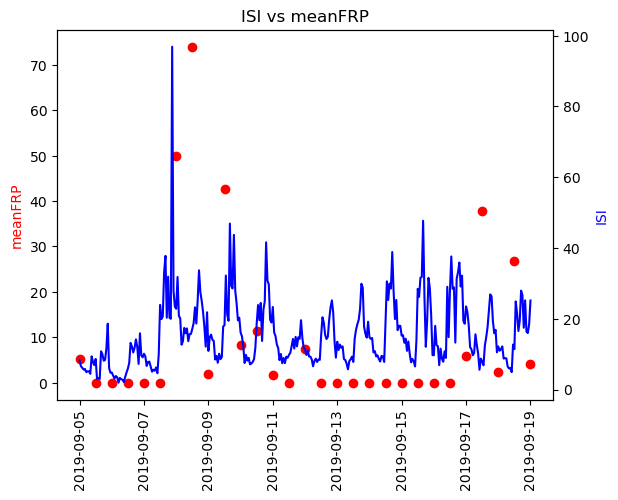

In [184]:
full_fr = full[(full.t >= min(full.t)) &  (full.t <= "2019-09-19")]
#full_fr = full


met = ['TEMP_C', 'RH_PERC', ' VPD_HPA', 'WDSPD_KPH',
       'FWI', 'PREC_MM', "ISI"]
fire = [ 'n_newpixels', 'flinelen','meanFRP',]

#n_met = len(met)
#n_fire = len(fire)

for m in met:
    for f in fire:
        fig, ax = plt.subplots()
        
        ax.scatter(full_fr["t"], full_fr[f], color = "r")
        #ax.plot(full_fr["t"], full_fr[m])
        #plt.xticks(rotation = 90)   
        ax.set_title(m + " vs " +  f)
        ax.set_ylabel(f, color = "red")
        ax2=ax.twinx()
        ax2.plot(full_fr["t"], full_fr[m],color="blue")
        ax2.set_ylabel(m,color="blue")
        ax.tick_params(axis='x', labelrotation = 90)

        plt.show()

In [185]:
# Plot without the diurnal cycle
full_fr_i = full_fr.dropna(subset = ['t'])

full_fr_i  = full_fr_i.set_index('t')

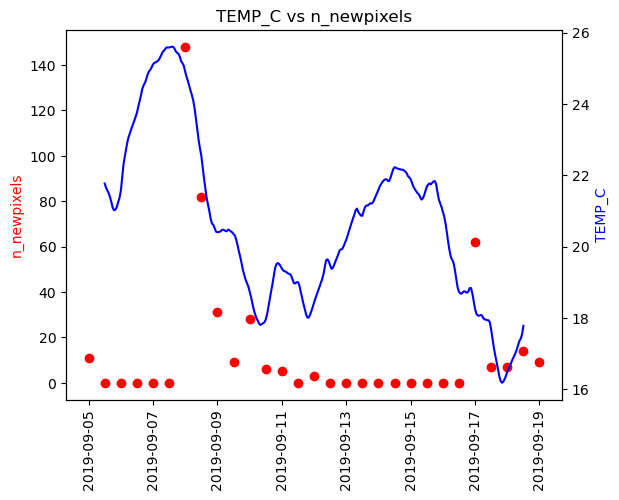

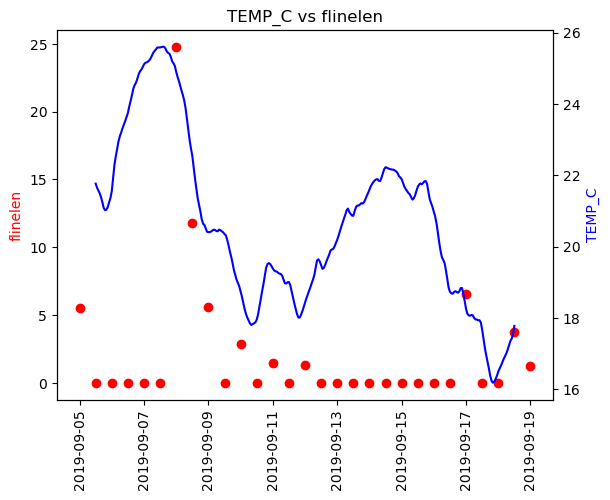

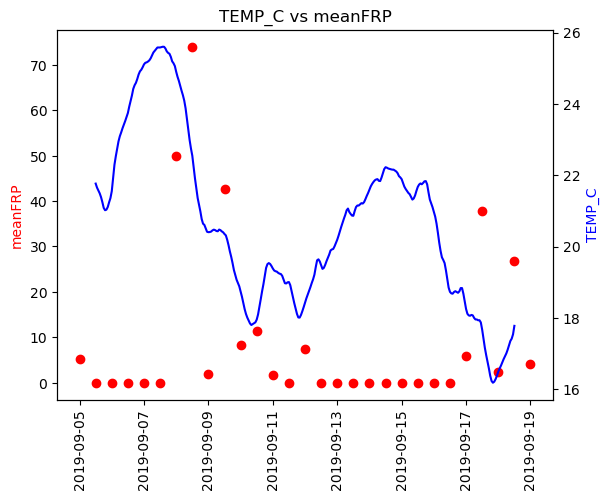

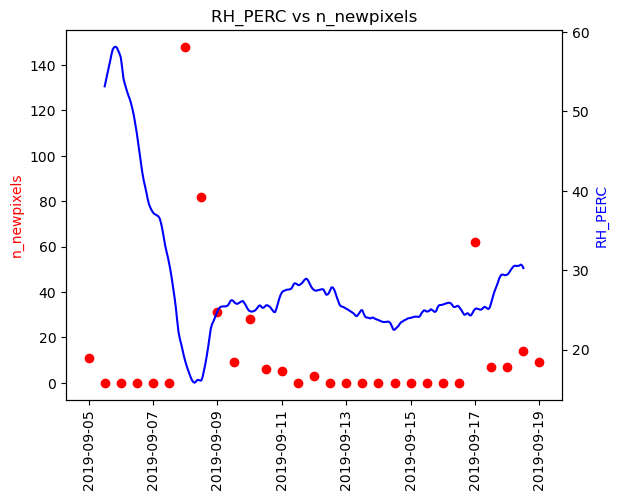

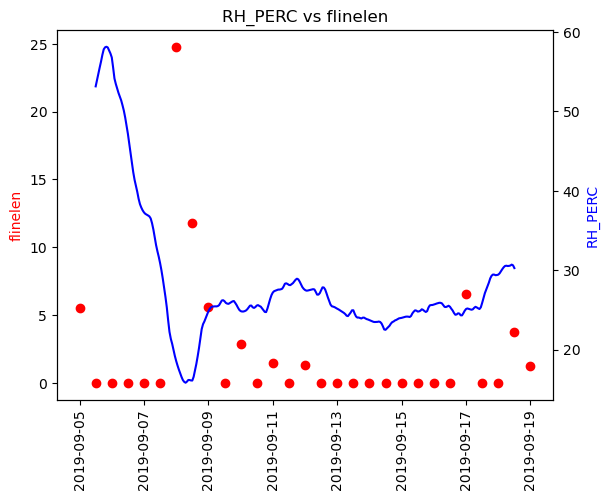

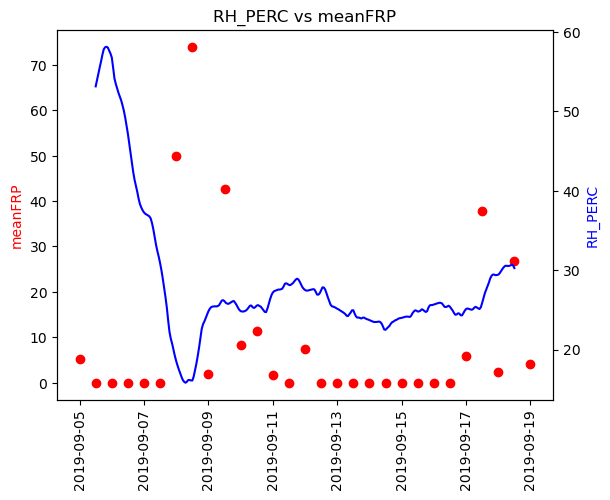

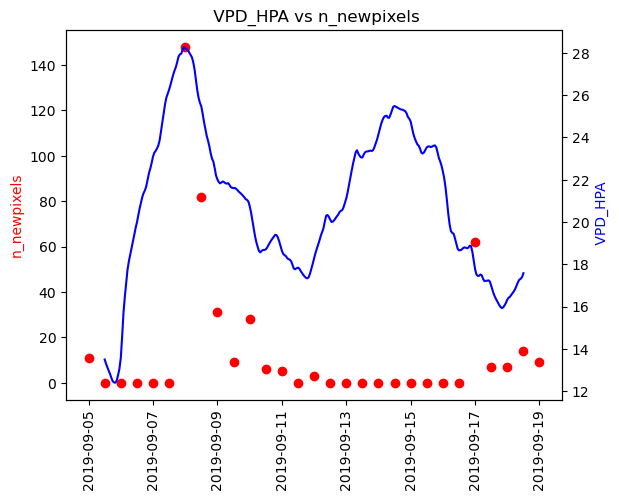

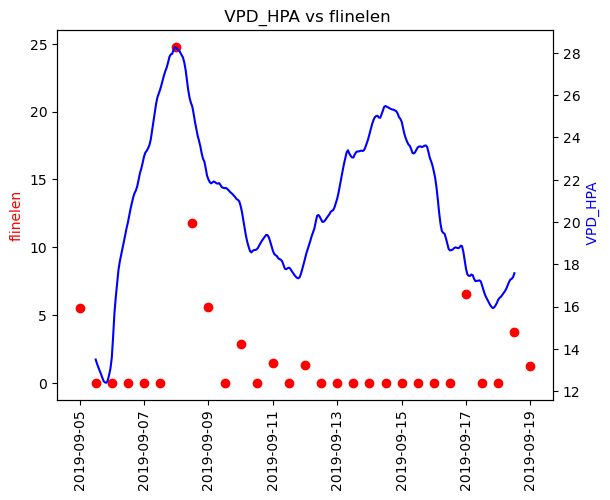

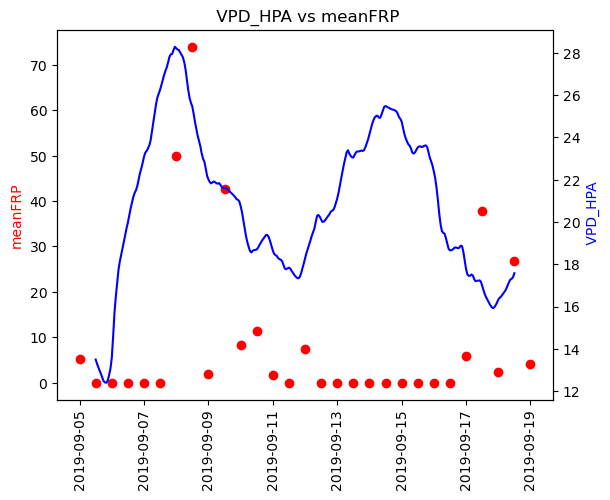

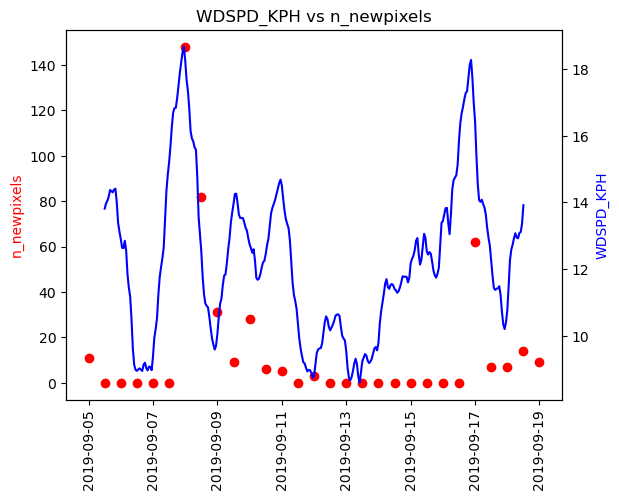

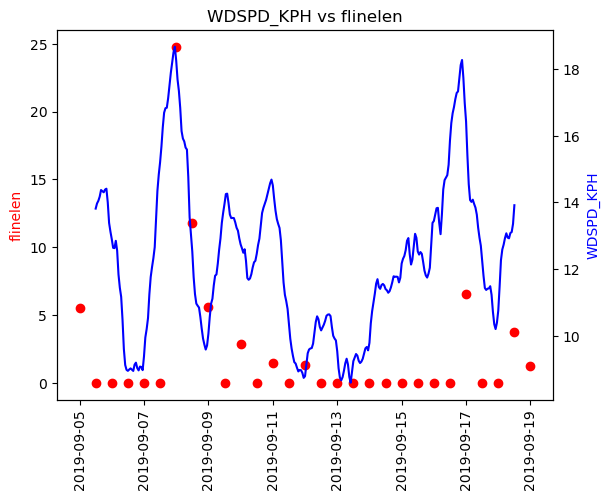

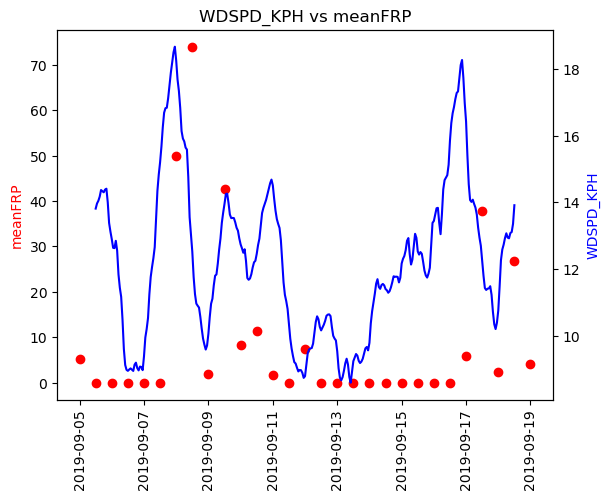

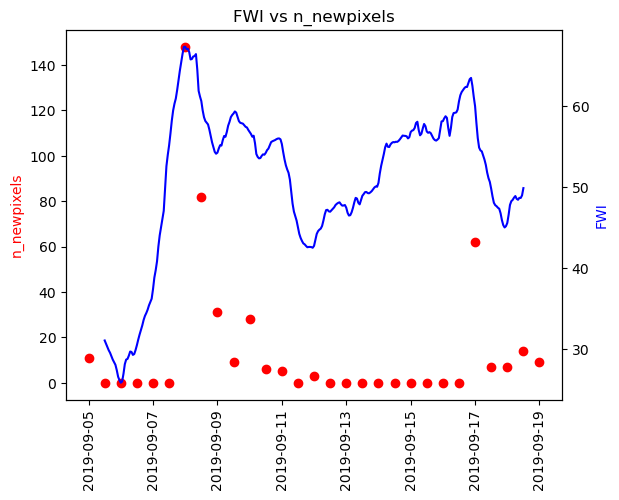

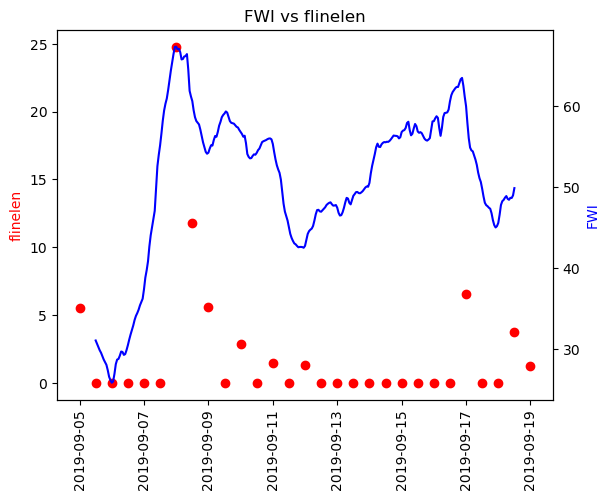

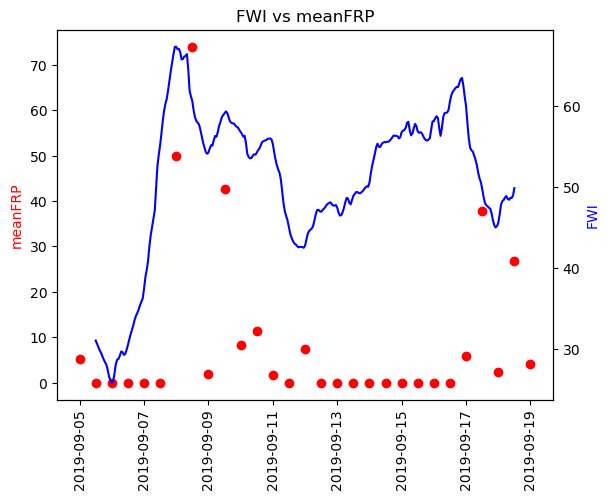

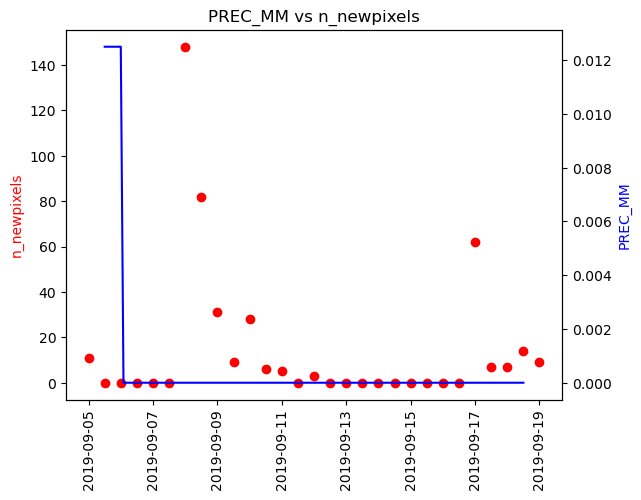

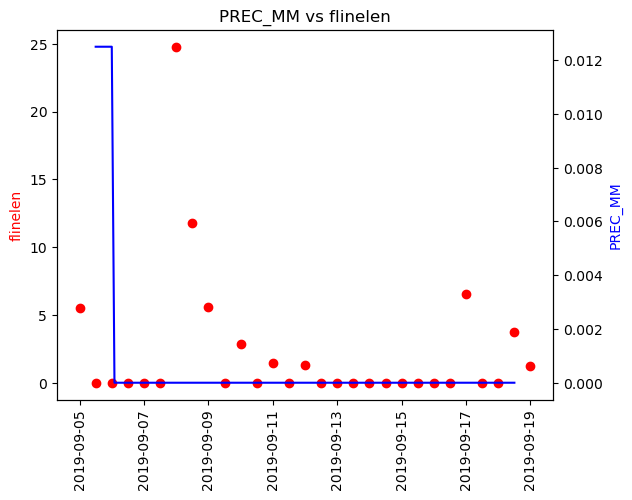

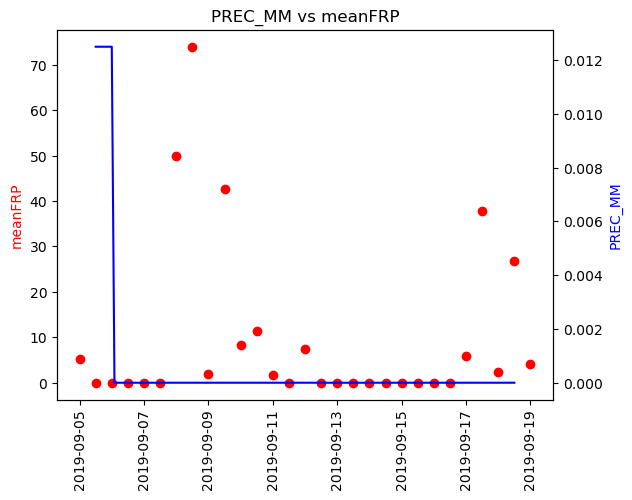

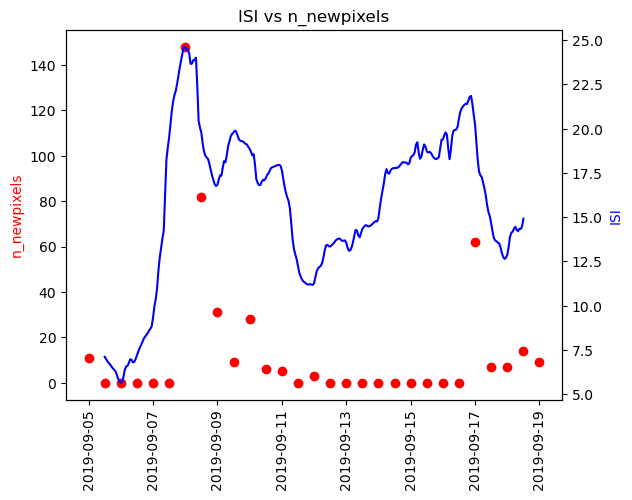

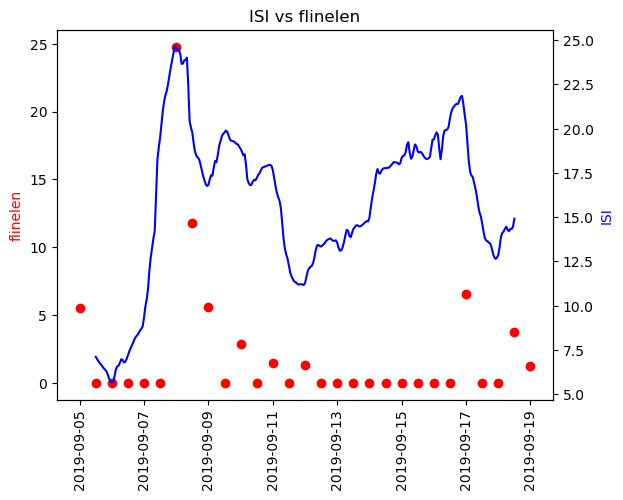

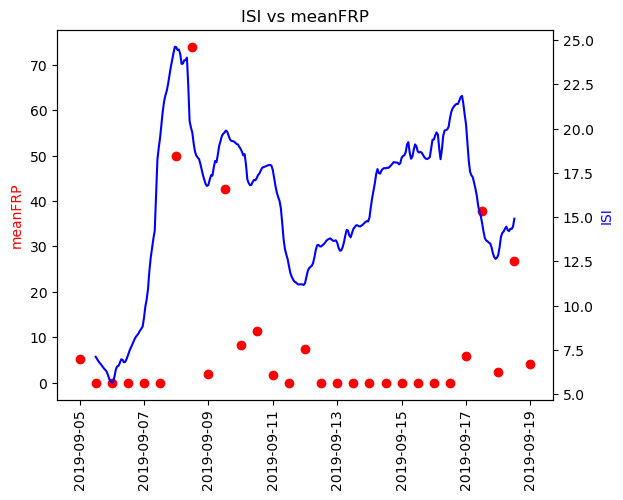

In [186]:



met = ['TEMP_C', 'RH_PERC', ' VPD_HPA', 'WDSPD_KPH',
       'FWI', 'PREC_MM', 'ISI']
fire = [ 'n_newpixels', 'flinelen','meanFRP',]


for m in met:
    met_decomp = seasonal_decompose(full_fr_i[m], model="additive")

    for f in fire:
        fig, ax = plt.subplots()
        
        ax.scatter(full_fr_i.index, full_fr_i[f], color = "r")
        ax.set_title(m + " vs " +  f)
        ax.set_ylabel(f, color = "red")
        ax2=ax.twinx()
        ax2.plot(full_fr_i.index, met_decomp.trend,color="blue")
        ax2.set_ylabel(m,color="blue")
        ax.tick_params(axis='x', labelrotation = 90)

        plt.show()